<a href="https://colab.research.google.com/github/johngonzalezv/machine-learning/blob/main/Pron%C3%B3stico_de_readmisi%C3%B3n_de_pacientes_diab%C3%A9ticos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pronóstico de readmisión de pacientes diabéticos

**Introducción**:
Este [dataset](https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008#) representa 10 años (1999-2008) de atención clínica en 130 hospitales y redes integradas de prestación de servicios de EE. UU. Incluye más de 50 funciones que representan los resultados del paciente y del hospital. Se extrajo información de la base de datos para los ingresos que cumplieron con los siguientes criterios.

1. Es un ingreso hospitalario (una admisión hospitalaria).
2. Es un ingreso diabético, es decir, durante el cual se ingresó al sistema cualquier tipo de diabetes como diagnóstico.
3. La duración de la estancia fue de al menos 1 día y como máximo 14 días.
4. Se realizaron pruebas de laboratorio durante la estancia.
5. Se administraron medicamentos durante la estancia.

Los datos contienen atributos tales como número de paciente, raza, sexo, edad, tipo de admisión, tiempo en el hospital, especialidad médica del médico que lo admite, número de pruebas de laboratorio realizadas, resultado de la prueba de HbA1c, diagnóstico, cantidad de medicación, medicamentos para diabéticos, cantidad de pacientes ambulatorios , visitas hospitalarias y urgentes en el año anterior a la hospitalización, etc. Para cada registro existe uno de los siguientes resultados:

* No readmisión;
* Readmisión en menos de 30 días (esta situación no es buena, porque existe la posibilidad de que el tratamiento aplicado no fue apropiado);
* Readmisión después de 30 días (esta situación tampoco es buena, sin embargo, la razón podría estar relacionada con el estado del paciente).

**Objetivo**: Clasificar el resultado de readmisión de un paciente.

## Se instalan y cargan las librerías necesarias

In [172]:
! pip install sweetviz
! pip install xgboost
! pip install 'sklearn-pandas'

In [364]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv

from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn_pandas import gen_features

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

## Se cargan los datos

Los datos se encuentran almacenados en *Google Drive*, se accede a la tabla de la siguiente manera y se revisan algunos de ellos.

In [129]:
df = pd.read_csv('https://drive.google.com/uc?id=1eTY9etz5bGiwW3-tjvDUxvSAkBE5MGeB')
df.head()

In [ ]:
print('cantidad de registros:', len(df))

101766

En seguida se observa que muchas variables son de tipo no numérico y se deberá realizar un tratamiento especial con estos, para conocer su tipo.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

Se revisa algunos estadísticos básicos, se encuentra que la mayoría de variables tienen sesgo, dado que existe diferencia significativa entre la media y la mediana. Esto puede influir en el correcto desarrollo del modelo.

In [ ]:
df.describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


En seguida se presenta algunos estadísticos básicos para las variables no numéricas. Llama la atención que las variables `diag_1`, `diag_2` y `diag_3` tienen bastantes factores. Por lo cual será necesario simplificarlas para incoporarlas en el modelo como variables *dummies*.

In [ ]:
df.describe(include=np.object)

,race,gender,age,weight,payer_code,medical_specialty,diag_1,diag_2,diag_3,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
count,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766
unique,6,3,10,10,18,73,717,749,790,4,4,4,4,4,4,4,2,4,4,2,4,4,4,4,2,3,1,1,4,4,2,2,2,2,2,2,3
top,Caucasian,Female,[70-80),?,?,?,428,276,250,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
freq,76099,54708,26068,98569,40256,49949,6862,6752,11555,96420,84748,81778,100227,101063,101680,96575,101765,89080,91116,101743,94438,95401,101458,101728,101763,101727,101766,101766,47383,101060,101753,101765,101764,101765,54755,78363,54864


Se remueven los registros duplicados, con ayuda de la variable `patient_nbr`. El cual contiene un código de identificación único para cada paciente

## Ingeniería de características

En seguida se realizan algunas transformaciones de las variables con el fin de incorporarlas en el modelo de pronóstico.

In [130]:
df.drop_duplicates(['patient_nbr'], keep = 'first', inplace = True)
print('Longitud despues de remover pacientes duplicados:', len(df))

Longitud despues de remover pacientes duplicados: 71518


Algunas variables son categóricas, se crea una función que se especializará en convertirlas.

In [131]:
def to_categorical(var):
  '''Return dtype categorical variable'''
  return df[var].astype('category')

cat_vars = list(df.select_dtypes(include=['object']).columns)

for cat_var in cat_vars:
  df[cat_var] = to_categorical(cat_var)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71518 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   encounter_id              71518 non-null  int64   
 1   patient_nbr               71518 non-null  int64   
 2   race                      71518 non-null  category
 3   gender                    71518 non-null  category
 4   age                       71518 non-null  category
 5   weight                    71518 non-null  category
 6   admission_type_id         71518 non-null  int64   
 7   discharge_disposition_id  71518 non-null  int64   
 8   admission_source_id       71518 non-null  int64   
 9   time_in_hospital          71518 non-null  int64   
 10  payer_code                71518 non-null  category
 11  medical_specialty         71518 non-null  category
 12  num_lab_procedures        71518 non-null  int64   
 13  num_procedures            71518 non-null  int

La variable edad está dada en intervalos, para manejarla como numérica se convierte a variable intervalo y se toma el punto medio. A esta variable se denomina `age_mid`.

In [132]:
str_intervals = [i.replace("[","").replace(")", "").split("-") for i in df.age]
df['age'] = pd.IntervalIndex([pd.Interval(float(i), float(j), closed='left') for i, j in str_intervals])
df['age_mid'] = df['age'].apply(lambda x: x.mid)

En algunas variables el símbolo '?' representa valores nulos o perdidos. Entonces se convierten a `np.nan`. Más adelante se utiliza un método de imputación para incorporar estos valores en el modelo.

In [133]:
df[cat_vars] = df[cat_vars].replace(['?', 'Unknown/Invalid'], np.nan)

Algunas variables tienen bastantes categorías (factores) que tienen un significado similar. Con ayuda del trabajo de 
[ranveerkln](https://https://medium.com/analytics-vidhya/diabetes-130-us-hospitals-for-years-1999-2008-e18d69beea4d) quien demuestra experticia en el tratamiento médico de esta información se consigue reducir la cantidad de factores.

Por otro lado, algunas variables son ordinales, para esto se reemplazan por valores numéricos que representan su orden.

In [135]:
df['discharge_disposition_id'] = df['discharge_disposition_id'].apply(lambda x : 1 if int(x) in [6, 8, 9, 13] 
                                                                           else ( 2 if int(x) in [3, 4, 5, 14, 22, 23, 24]
                                                                           else ( 10 if int(x) in [12, 15, 16, 17]
                                                                           else ( 11 if int(x) in [19, 20, 21]
                                                                           else ( 18 if int(x) in [25, 26] 
                                                                           else int(x) ))))).astype('category')

# Se eliminan los registros cuyos pacientes no están discharged.
# 11. Expired
# 13. Hospice / home
# 14. Hospice / medical facility
# 19. Expired at home. Medicaid only, hospice.
# 20. Expired in a medical facility. Medicaid only, hospice.
# 21. Expired, place unknown. Medicaid only, hospice.
df = df[~df.discharge_disposition_id.isin([11,13,14,19,20,21])]

df['admission_type_id'] = df['admission_type_id'].apply(lambda x : 1 if int(x) in [2, 7]
                                                            else ( 5 if int(x) in [6, 8]
                                                            else int(x) )).astype('category')

df['admission_source_id'] = df['admission_source_id'].apply(lambda x : 1 if int(x) in [2, 3]
                                                            else ( 4 if int(x) in [5, 6, 10, 22, 25]
                                                            else ( 9 if int(x) in [15, 17, 20, 21]
                                                            else ( 11 if int(x) in [13, 14]
                                                            else int(x) )))).astype('category')

for col in ["metformin", "repaglinide", "nateglinide", "chlorpropamide", "glimepiride", "acetohexamide", "glipizide", "glyburide", "tolbutamide", "pioglitazone", "rosiglitazone", "acarbose", "miglitol", "troglitazone", "tolazamide", "examide", "citoglipton", "insulin", "glyburide-metformin", "glipizide-metformin", "glimepiride-pioglitazone", "metformin-rosiglitazone", "metformin-pioglitazone"]:
    df[col] = df[col].apply(lambda x : 10 if x == 'Up' 
                                              else ( -10 if x == 'Down'                                                          
                                              else ( 0 if x == 'Steady'
                                              else  -20))).astype('int')


df['change'] = df['change'].apply(lambda x : 1 if x == 'Ch'
                                                 else -1).astype('category')


df['diabetesMed'] = df['diabetesMed'].apply(lambda x : -1 if x == 'No'
                                                else 1).astype('category')


df['max_glu_serum'] = df['max_glu_serum'].apply(lambda x : 200 if x == '>200' 
                                                            else ( 300 if x == '>300'                                                          
                                                            else ( 100 if x == 'Norm'
                                                            else  0))).astype('int')

df['A1Cresult'] = df['A1Cresult'].apply(lambda x : 7 if x == '>7' 
                                                         else (8 if  x == '>8'                                                        
                                                         else ( 5 if x == 'Norm'
                                                         else  0))).astype('int')

Como se dijo anteriormente, las variables `diag_x` contienen bastantes categorías o factores. Se define la función `reduce_diag_types` para reducir la cantidad de categorías de acuerdo al trabajo [ranveerkln](https://https://medium.com/analytics-vidhya/diabetes-130-us-hospitals-for-years-1999-2008-e18d69beea4d).

In [136]:
def reduce_diag_types(var):
  '''Reduce diagnostic types'''
  return df[var].apply(lambda x : 'other'            if (str(x).find('V') != -1 or str(x).find('E') != -1)  
                                        else ('circulatory'     if int(float(x)) in range(390, 460) or int(float(x)) == 785
                                        else ('respiratory'     if int(float(x)) in range(460, 520) or int(float(x)) == 786
                                        else ('digestive'       if int(float(x)) in range(520, 580) or int(float(x)) == 787
                                        else ('diabetes'        if int(float(x)) == 250
                                        else ('injury'          if int(float(x)) in range(800, 1000)
                                        else ('musculoskeletal' if int(float(x)) in range(710, 740)
                                        else ('genitourinary'   if int(float(x)) in range(580, 630) or int(float(x)) == 788
                                        else ('neoplasms'       if int(float(x)) in range(140, 240)
                                        else ('pregnecy'        if int(float(x)) in range(630, 680)
                                        else 'other')))))))))).astype('category')

df['diag_1'] = reduce_diag_types('diag_1')
df['diag_2'] = reduce_diag_types('diag_2')
df['diag_3'] = reduce_diag_types('diag_3')

Similarmente, se reduce la cantidad de factores para la variable `medical_speciality`.

In [137]:
high_frequency = ['InternalMedicine', 'Family/GeneralPractice', 'Cardiology', 'Surgery-General', 'Orthopedics', 'Orthopedics-Reconstructive', 
                 'Emergency/Trauma', 'Urology','ObstetricsandGynecology','Psychiatry','Pulmonology ','Nephrology','Radiologist']

low_frequency = ['Surgery-PlasticwithinHeadandNeck','Psychiatry-Addictive','Proctology','Dermatology','SportsMedicine','Speech','Perinatology',\
                'Neurophysiology','Resident','Pediatrics-Hematology-Oncology','Pediatrics-EmergencyMedicine','Dentistry','DCPTEAM','Psychiatry-Child/Adolescent',\
                'Pediatrics-Pulmonology','Surgery-Pediatric','AllergyandImmunology','Pediatrics-Neurology','Anesthesiology','Pathology','Cardiology-Pediatric',\
                'Endocrinology-Metabolism','PhysicianNotFound','Surgery-Colon&Rectal','OutreachServices',\
                'Surgery-Maxillofacial','Rheumatology','Anesthesiology-Pediatric','Obstetrics','Obsterics&Gynecology-GynecologicOnco']

pediatrics = ['Pediatrics','Pediatrics-CriticalCare','Pediatrics-EmergencyMedicine','Pediatrics-Endocrinology','Pediatrics-Hematology-Oncology',\
               'Pediatrics-Neurology','Pediatrics-Pulmonology', 'Anesthesiology-Pediatric', 'Cardiology-Pediatric', 'Surgery-Pediatric']

psychic = ['Psychiatry-Addictive', 'Psychology', 'Psychiatry',  'Psychiatry-Child/Adolescent', 'PhysicalMedicineandRehabilitation', 'Osteopath']


neurology = ['Neurology', 'Surgery-Neuro',  'Pediatrics-Neurology', 'Neurophysiology']


surgery = ['Surgeon', 'Surgery-Cardiovascular', \
          'Surgery-Cardiovascular/Thoracic', 'Surgery-Colon&Rectal', 'Surgery-General', 'Surgery-Maxillofacial', \
             'Surgery-Plastic', 'Surgery-PlasticwithinHeadandNeck',  'Surgery-Thoracic',\
             'Surgery-Vascular', 'SurgicalSpecialty', 'Podiatry']
             
ungrouped = ['Endocrinology','Gastroenterology','Gynecology','Hematology','Hematology/Oncology','Hospitalist','InfectiousDiseases',\
           'Oncology','Ophthalmology','Otolaryngology','Pulmonology','Radiology']

colMedical = []

for val in df['medical_specialty'] :
    if val in pediatrics :
        colMedical.append('pediatrics')
    elif val in psychic :
        colMedical.append('psychic')
    elif val in neurology :
        colMedical.append('neurology')
    elif val in surgery :
        colMedical.append('surgery')
    elif val in high_frequency :
        colMedical.append('high_freq')
    elif val in low_frequency :
        colMedical.append('low_freq')
    elif val in ungrouped :
        colMedical.append('ungrouped')
    else:
      colMedical.append(np.nan)

df['medical_specialty'] = pd.Series(colMedical).astype('category')

Al final se consigue el tipo adecuado de cada variable de la tabla de datos.

In [144]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70434 entries, 0 to 101765
Data columns (total 47 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   race                      68513 non-null  category
 1   gender                    70431 non-null  category
 2   admission_type_id         70434 non-null  category
 3   discharge_disposition_id  70434 non-null  category
 4   admission_source_id       70434 non-null  category
 5   time_in_hospital          70434 non-null  int64   
 6   medical_specialty         26747 non-null  category
 7   num_lab_procedures        70434 non-null  int64   
 8   num_procedures            70434 non-null  int64   
 9   num_medications           70434 non-null  int64   
 10  number_outpatient         70434 non-null  int64   
 11  number_emergency          70434 non-null  int64   
 12  number_inpatient          70434 non-null  int64   
 13  diag_1                    70423 non-null  cat

Por último, se eliminan las variables que no son relevantes para el objetivo.

In [ ]:
df.drop(['encounter_id', 'patient_nbr', 'weight', 'payer_code', 'age'], axis=1, inplace=True)

## Análisis descriptivo

En seguida se presenta un gráfico de frecuencia de pacientes readmitidos. Como se puede observar hay desbalance en la frecuencia de pacientes de la variable objetivo.

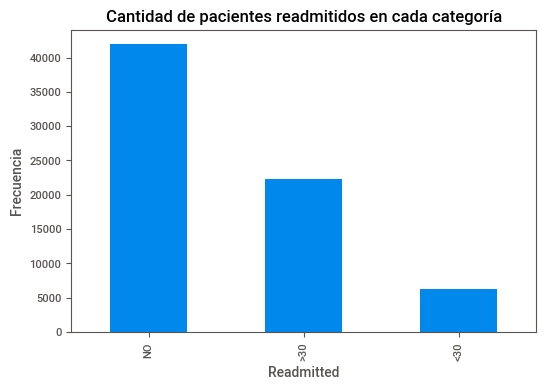

In [345]:
df.readmitted.value_counts().plot.bar()
plt.xlabel('Readmitted')
plt.ylabel('Frecuencia')
plt.title('Cantidad de pacientes readmitidos en cada categoría')
plt.show()

Como se puede observar los casos más graves (readmitidos antes de 30 días) son los de menor frecuencia.

A continuación se codifica numéricamente las categorías de los readmitidos así:
* `<30`: 0
* `>30`: 1
* `NO`: 2

Esto permitirá que algunas herramientas trabajen adecuadamente con esta variable

In [141]:
df['readmitted_cod'] = df.readmitted.cat.codes

Con ayuda del paquete `sweetviz` se genera un reporte estadístico descriptivo exploratorio (EDA).

In [142]:
feature_config = sv.FeatureConfig(skip="readmitted", force_num=["readmitted_cod"])
reporte = sv.analyze(df, target_feat='readmitted_cod', feat_cfg=feature_config)

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.



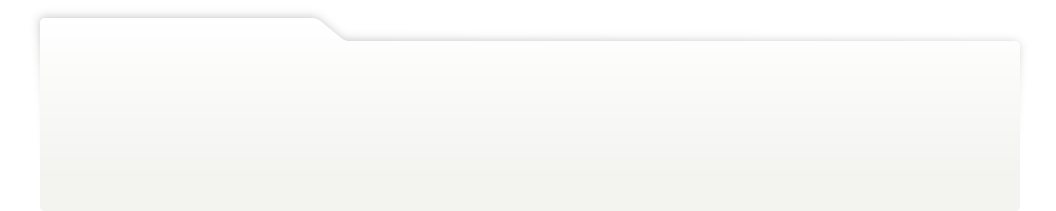
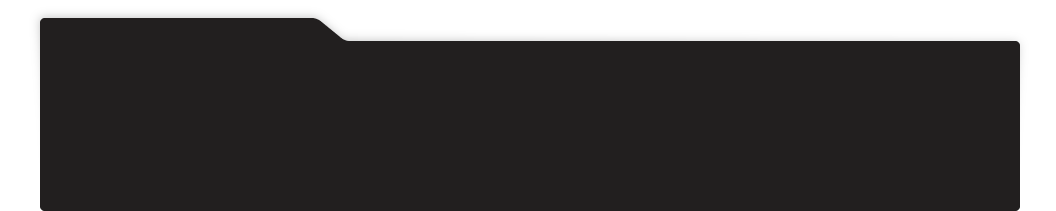
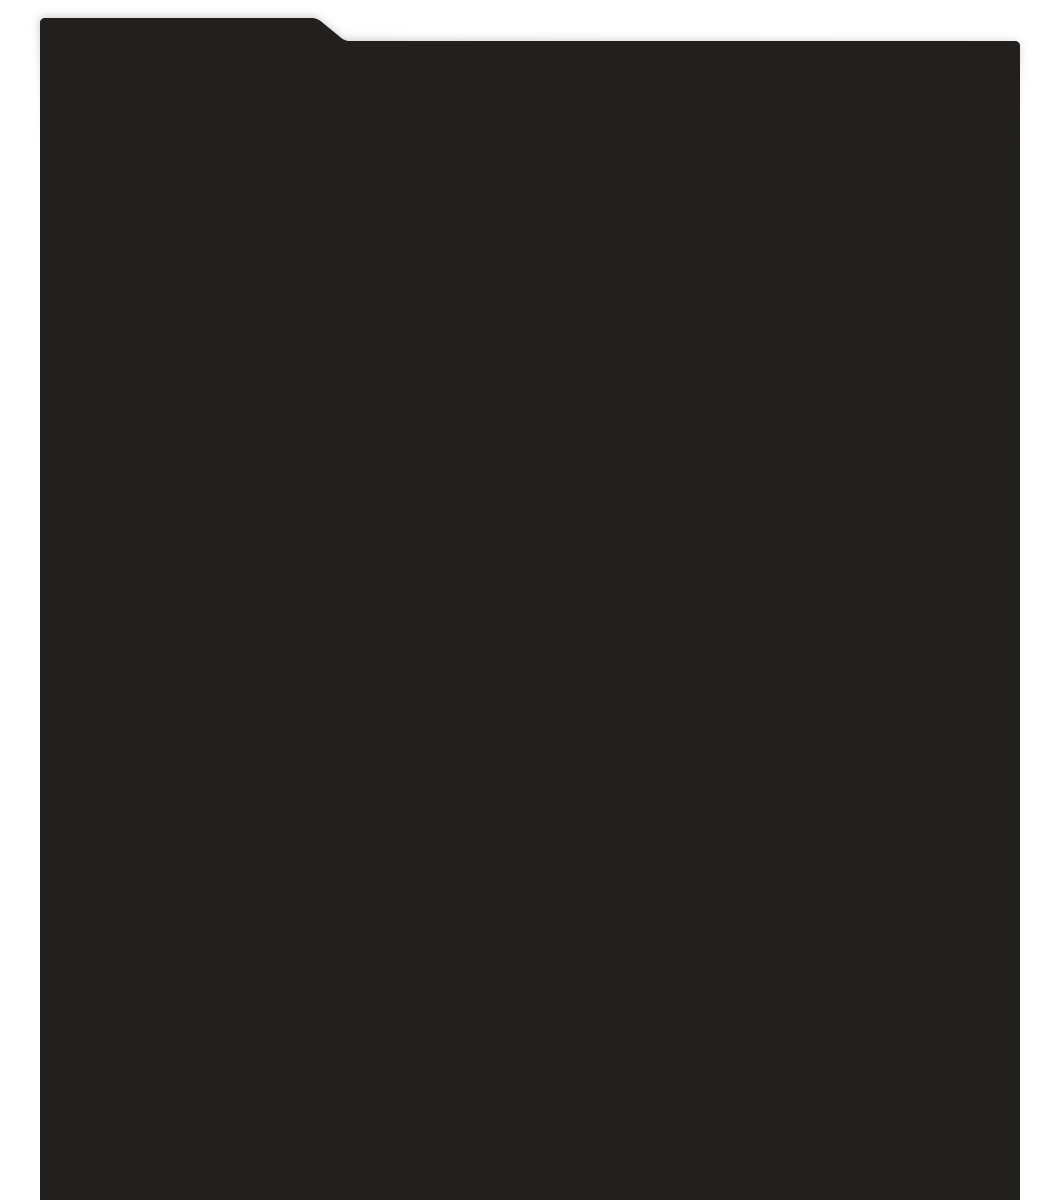
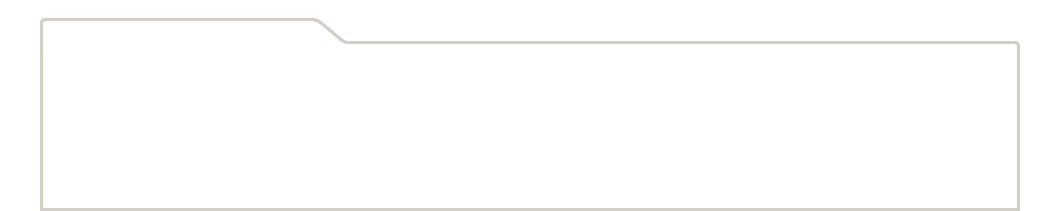
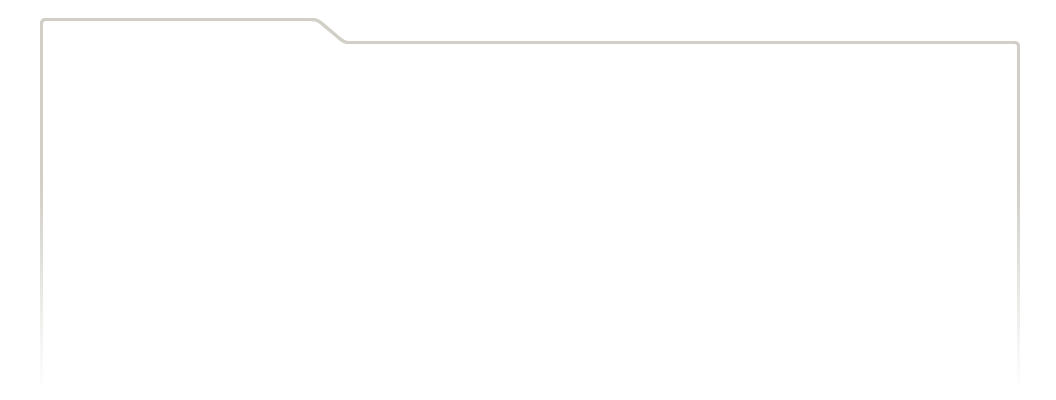
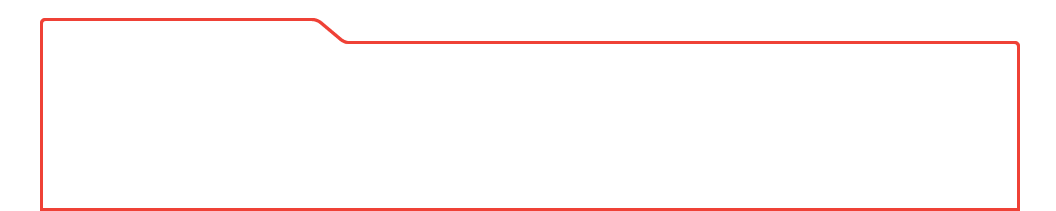
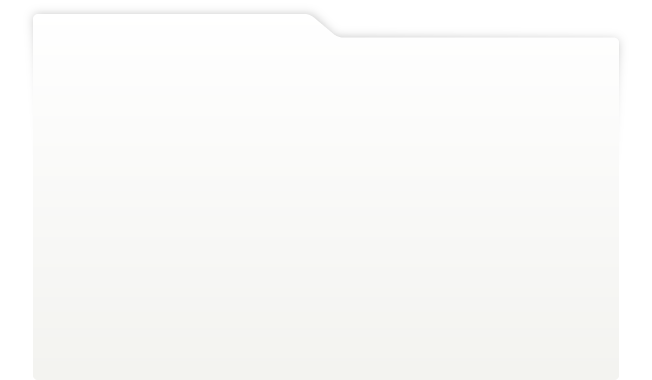
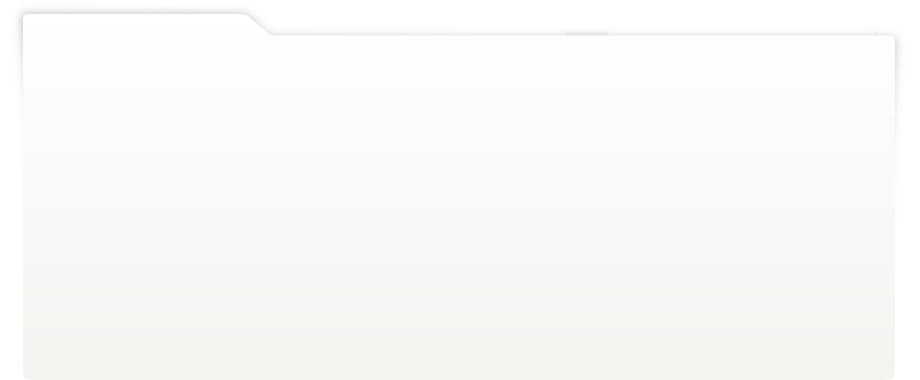
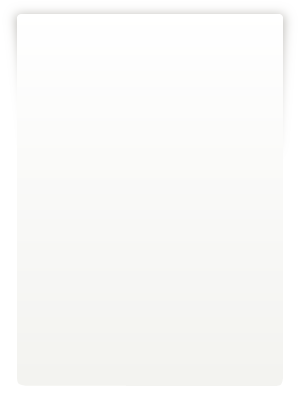
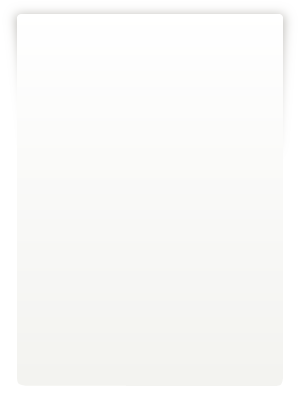
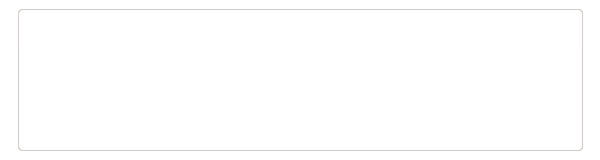
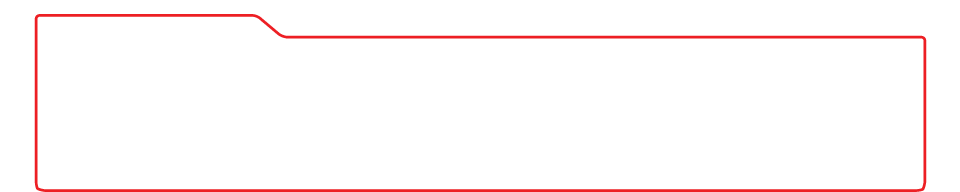
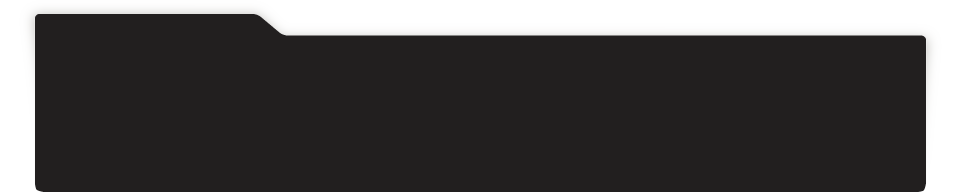
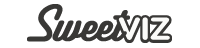
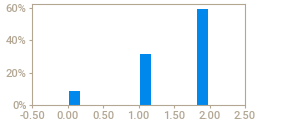
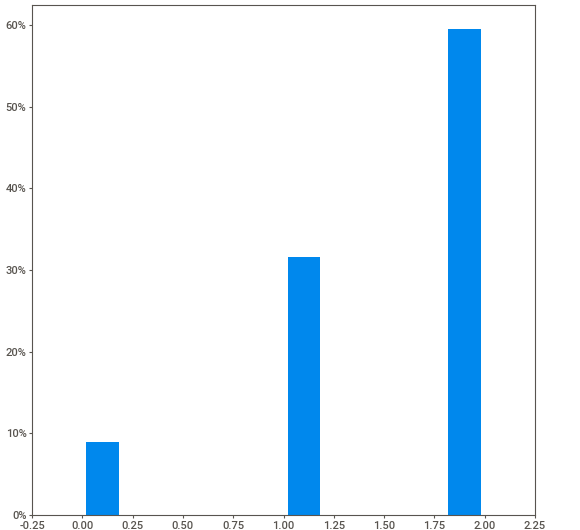
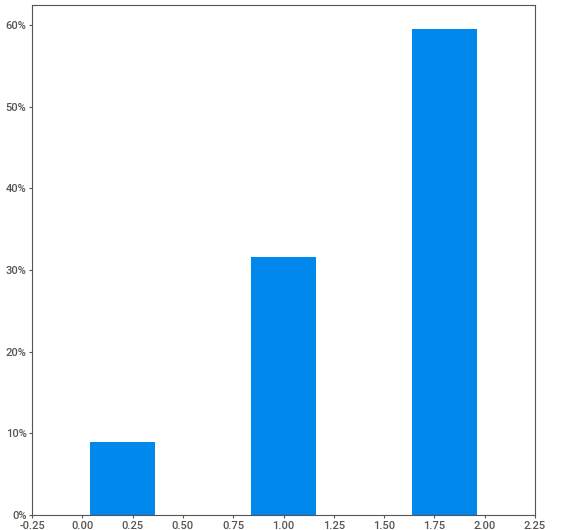
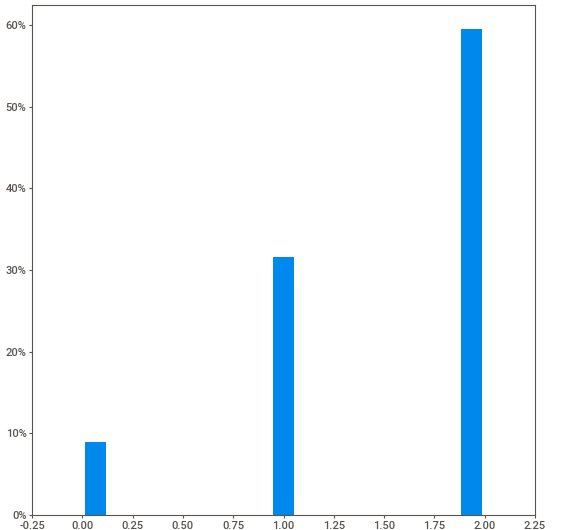
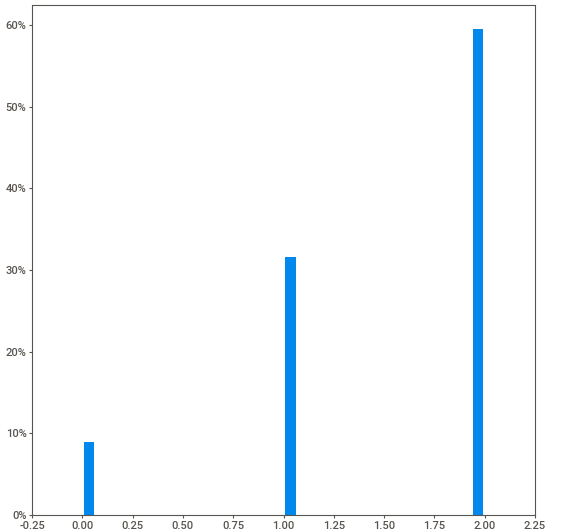
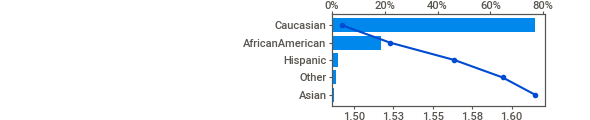
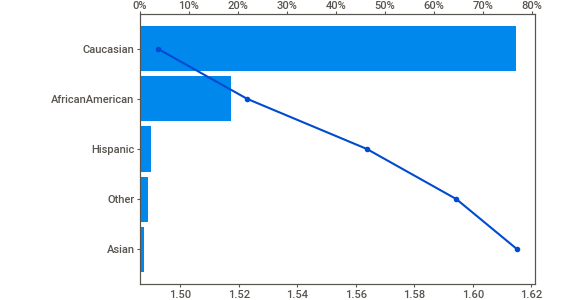
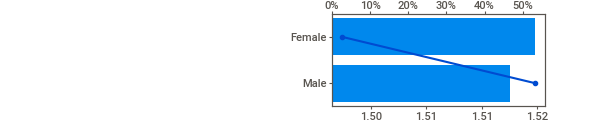
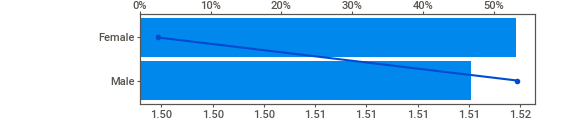
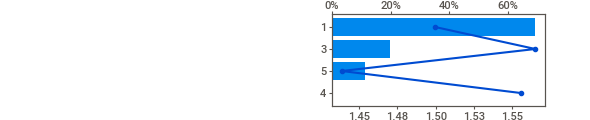
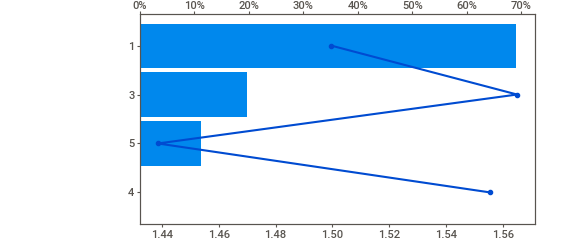
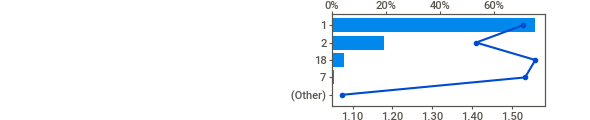
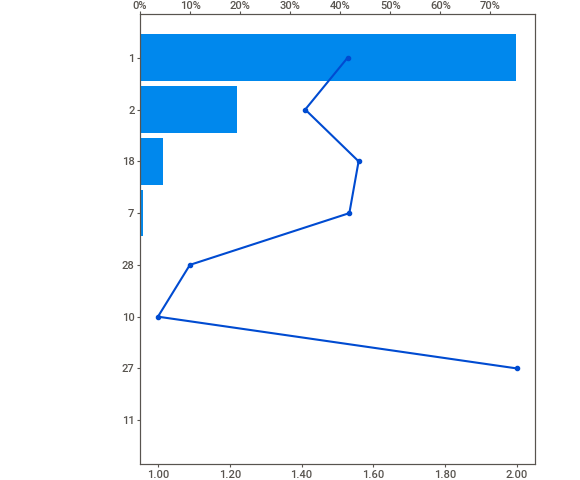
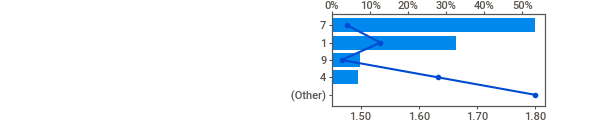
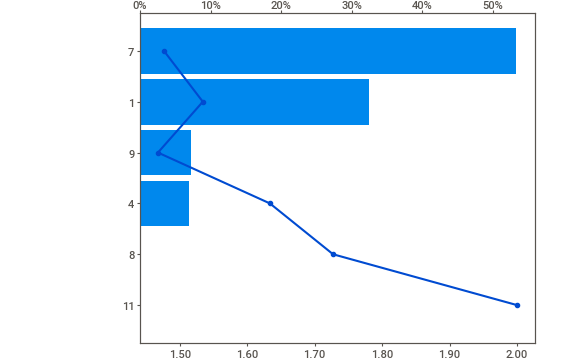
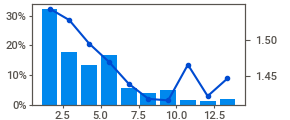
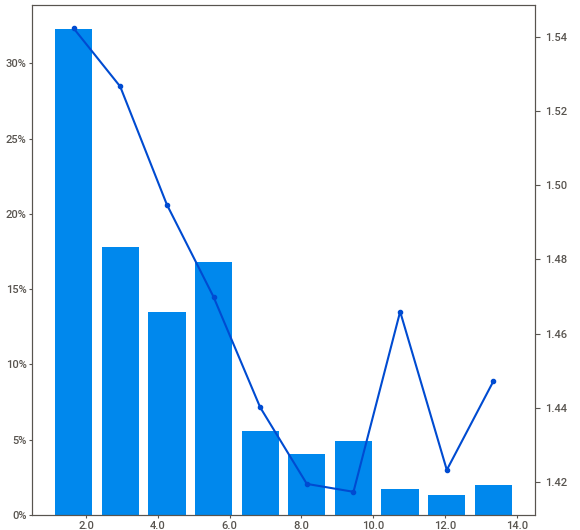
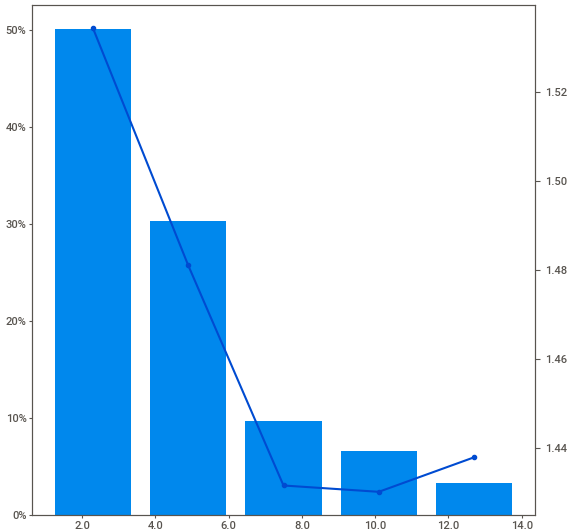
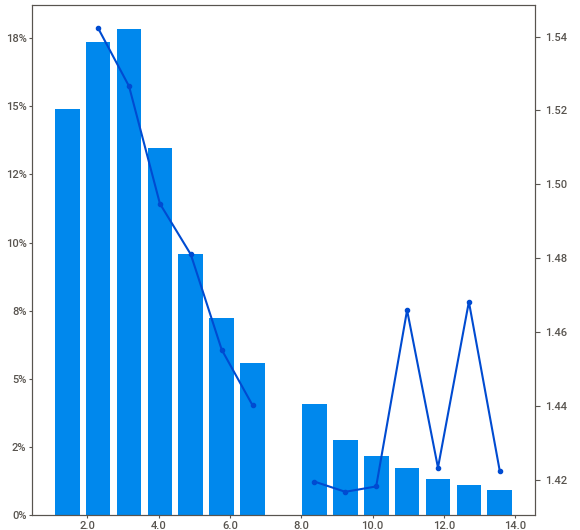
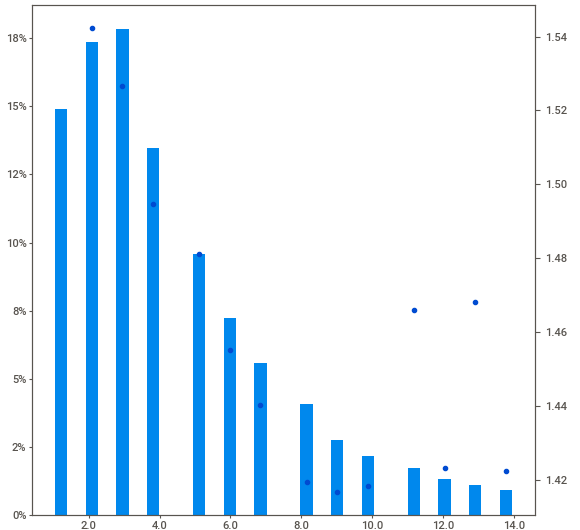
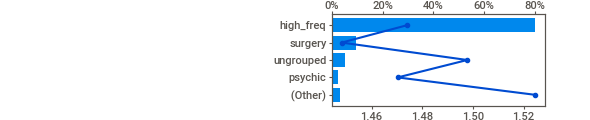
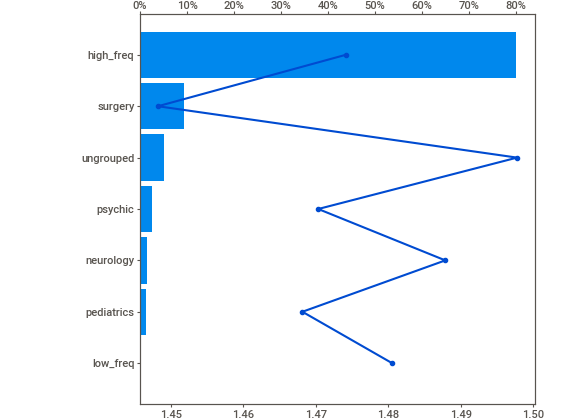
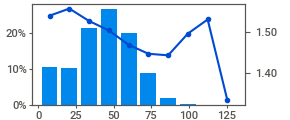
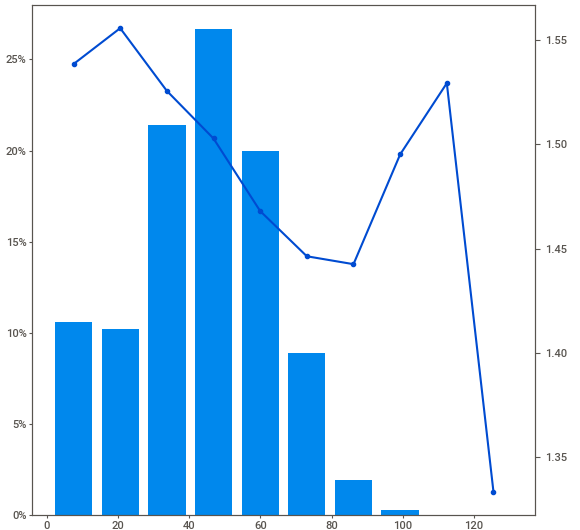
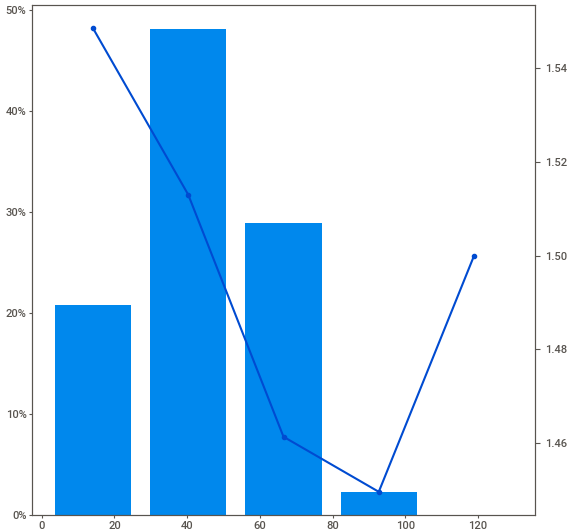
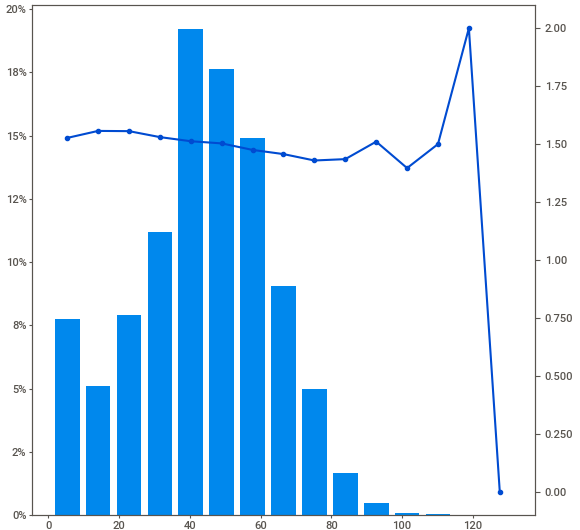
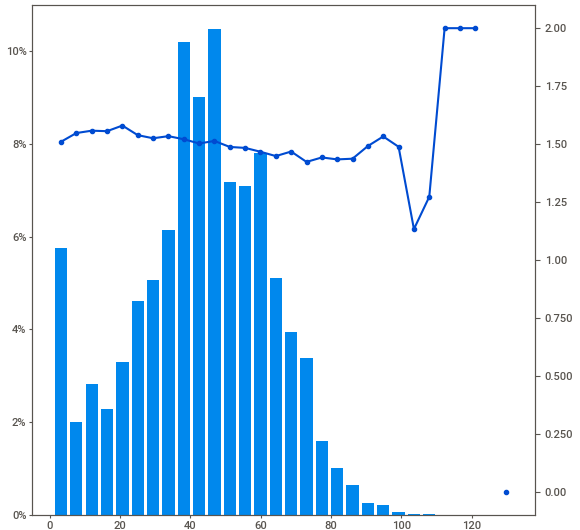
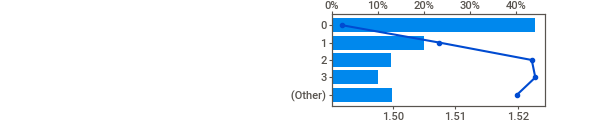
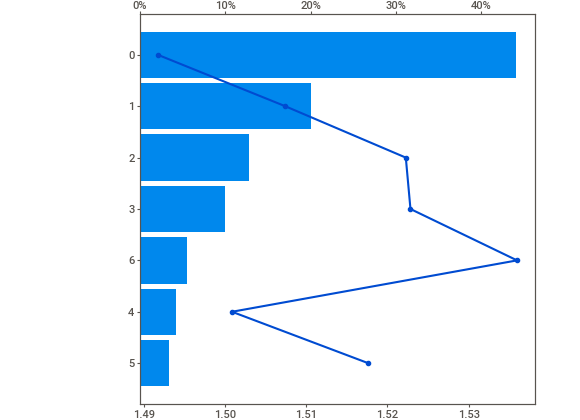
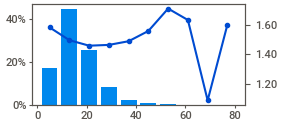
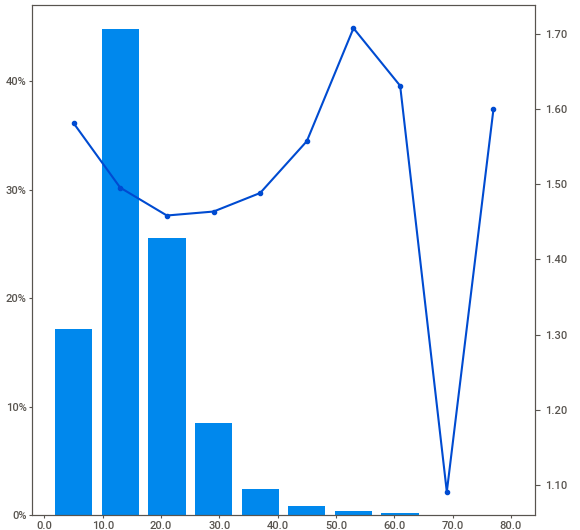
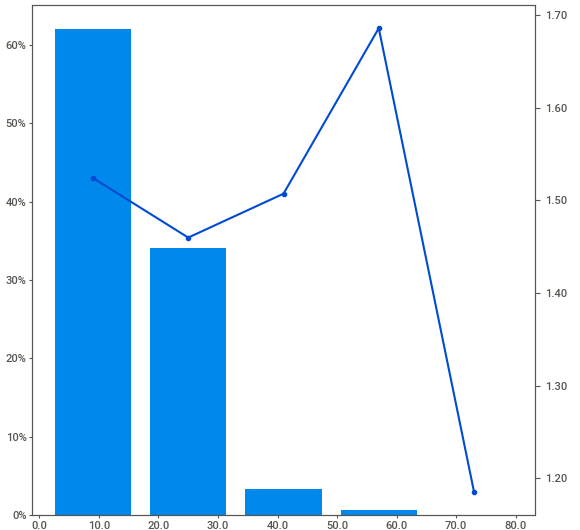
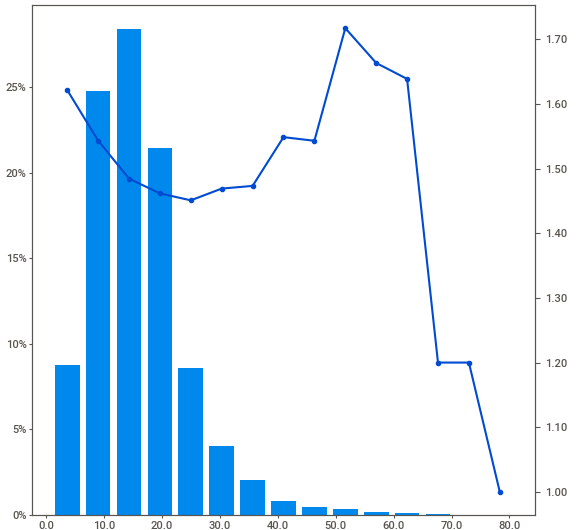
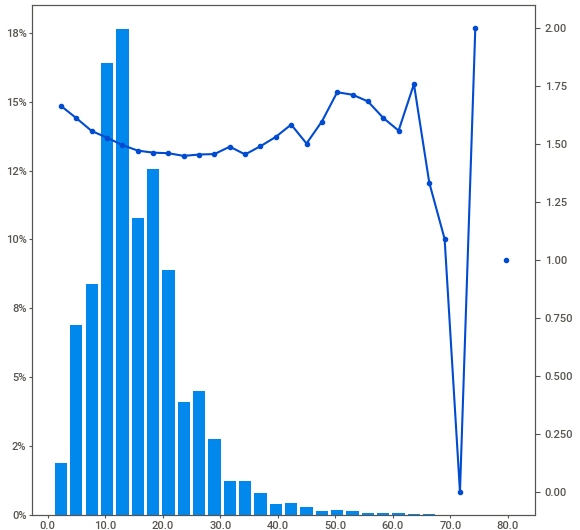
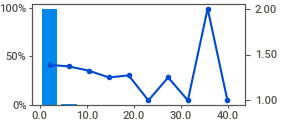
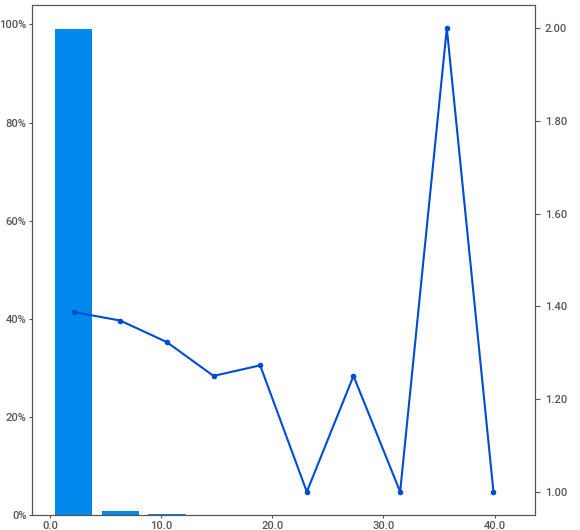
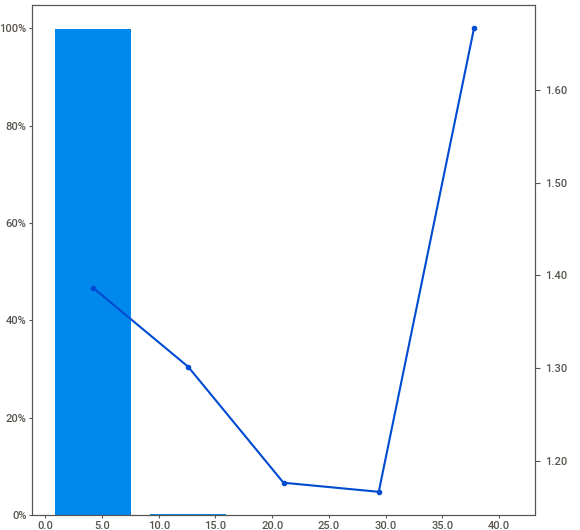
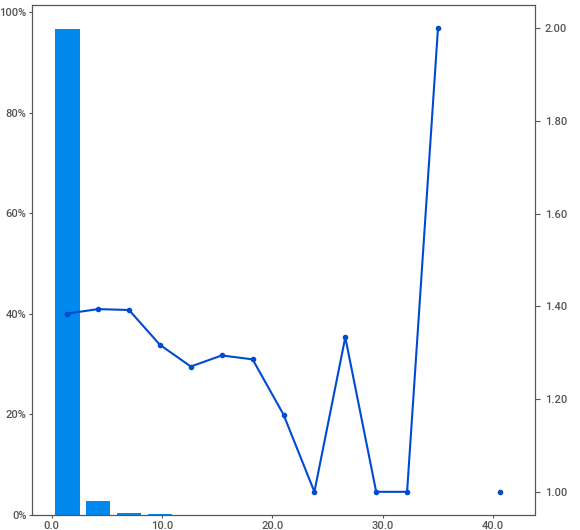
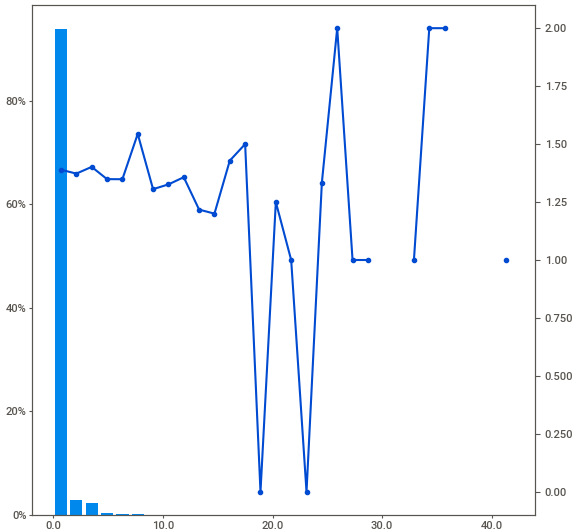
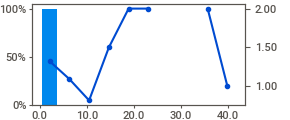
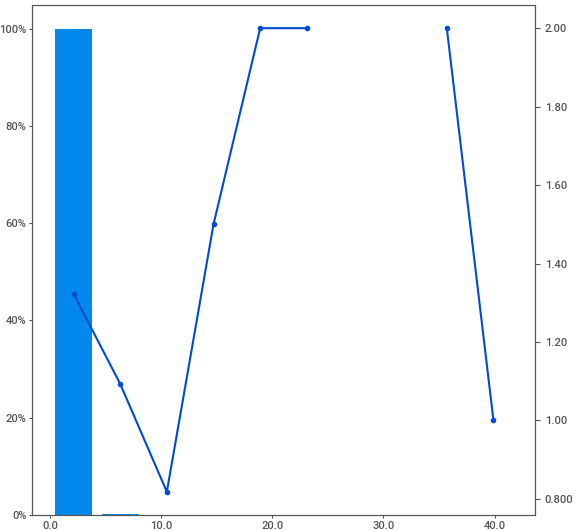
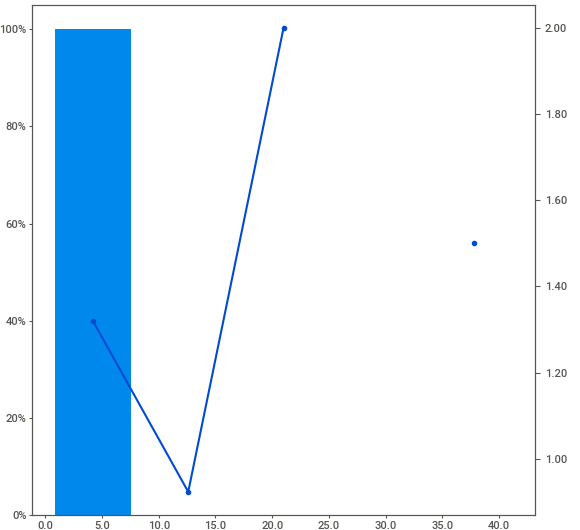
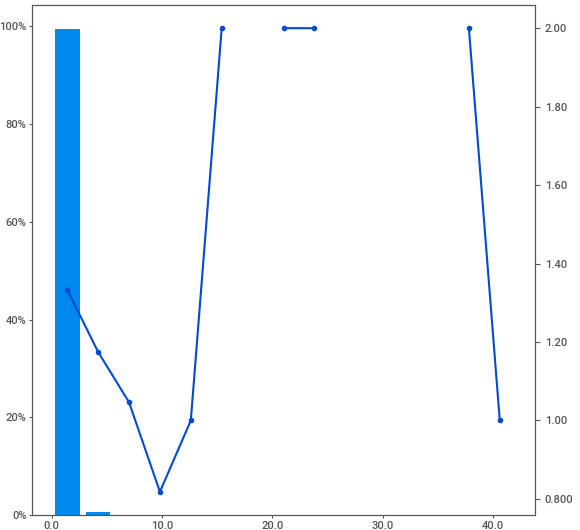
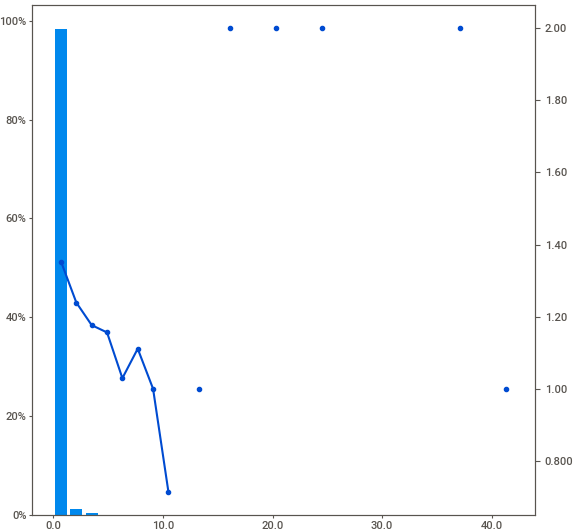
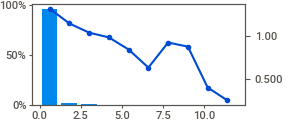
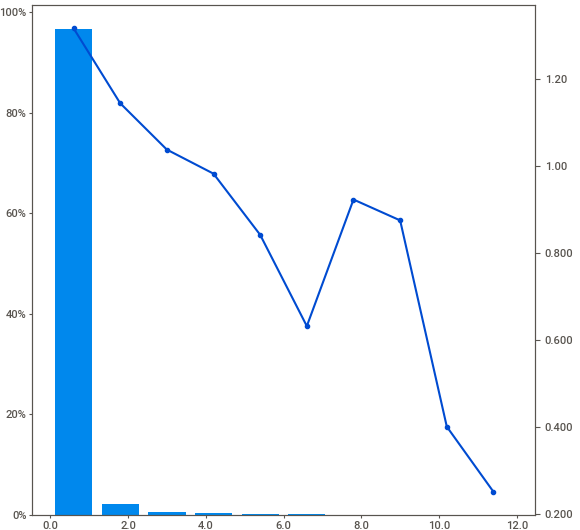
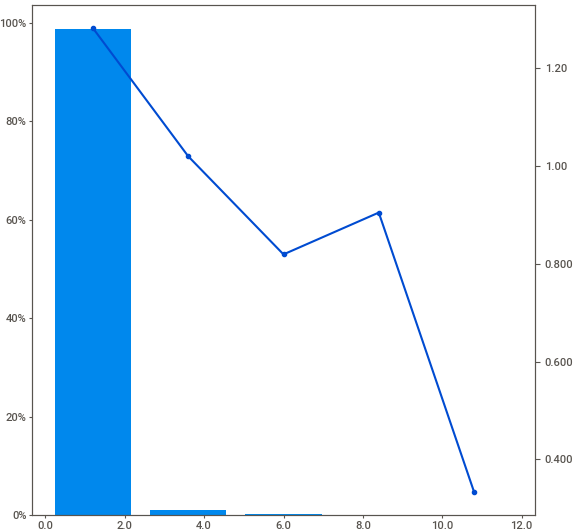
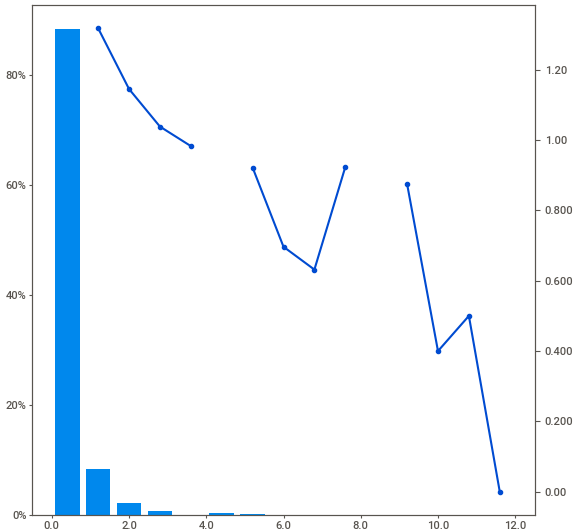
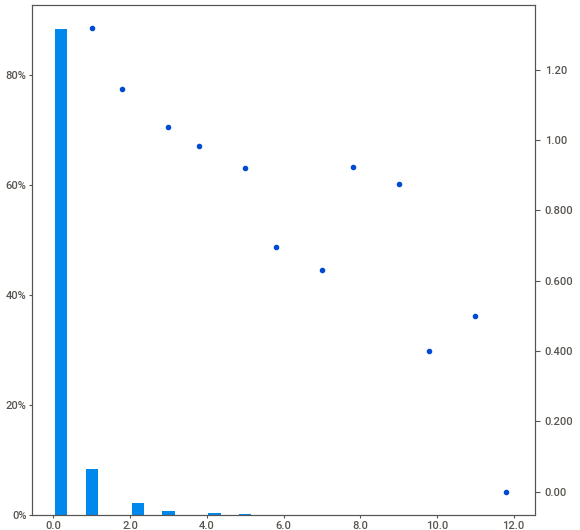
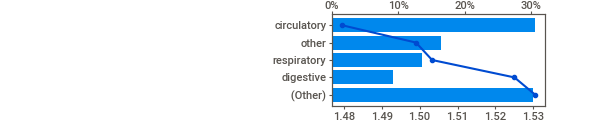
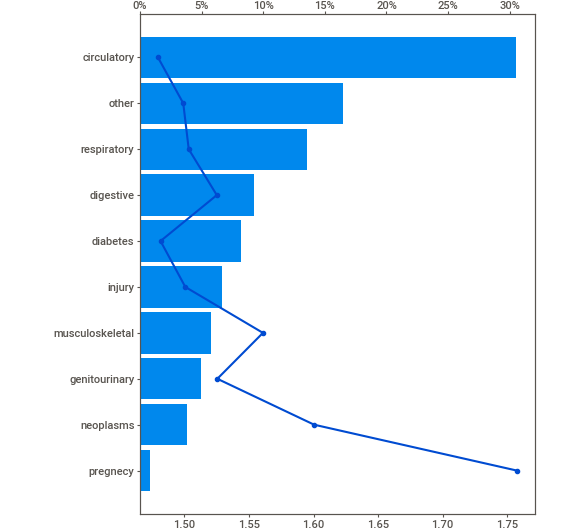
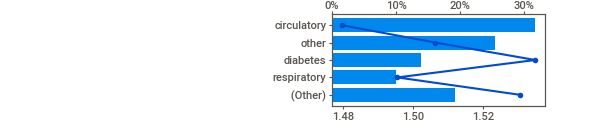
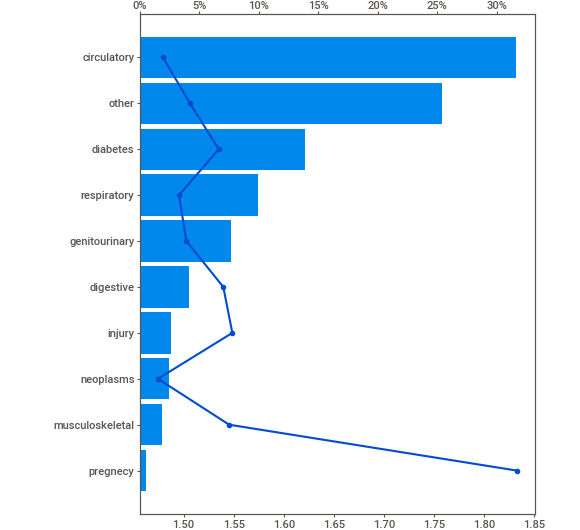
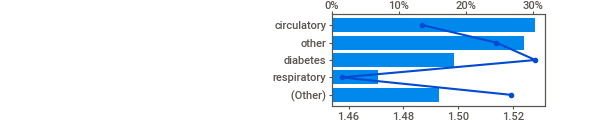
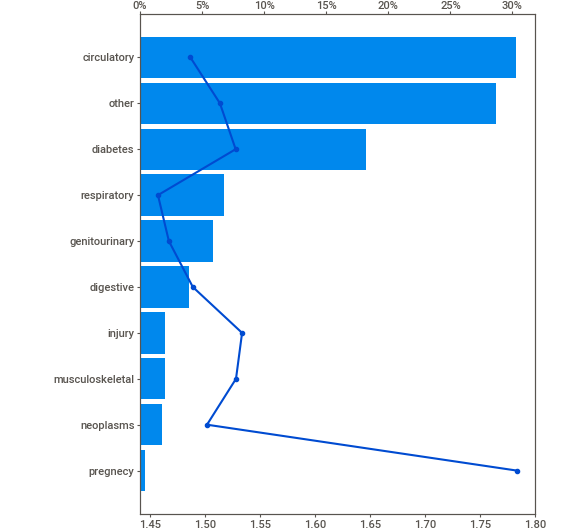
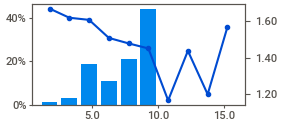
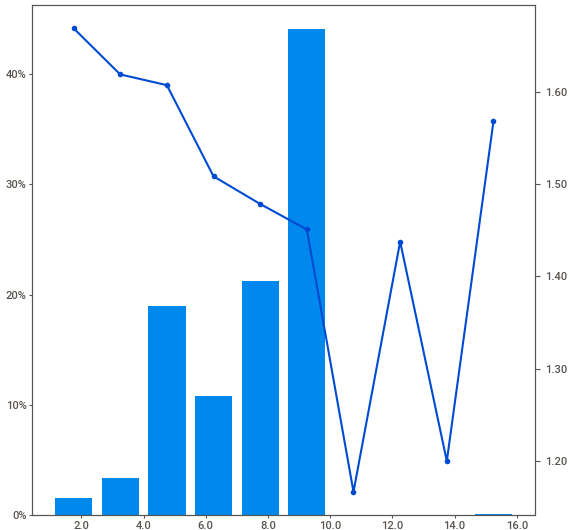
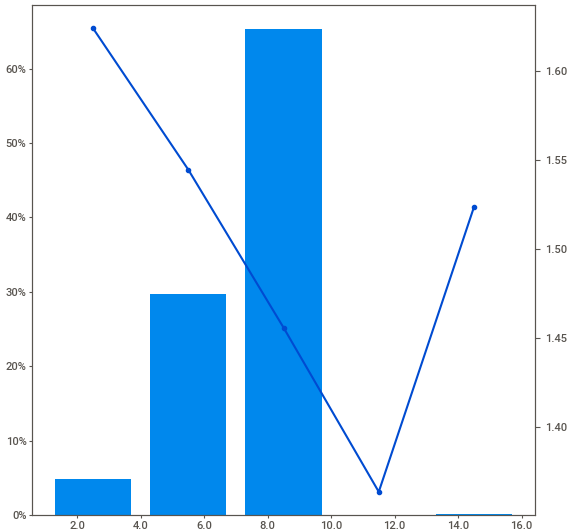
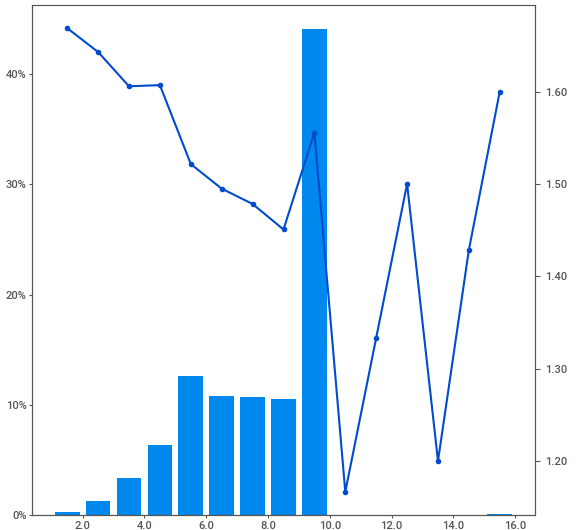
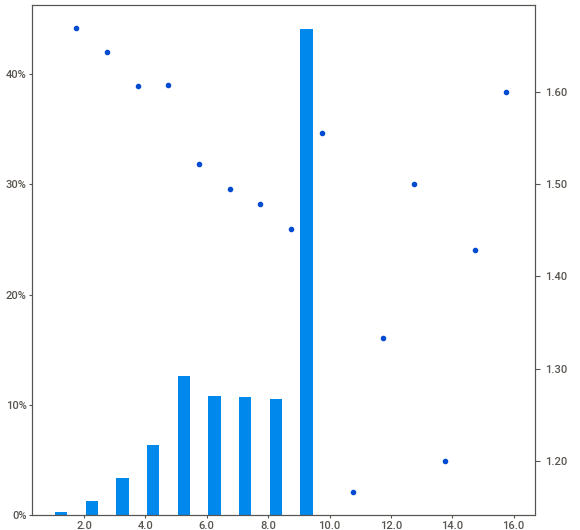
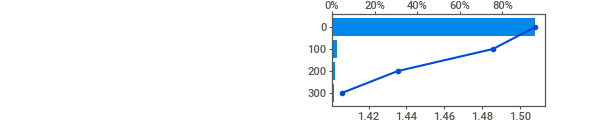
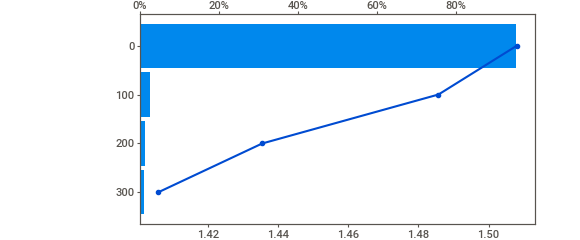
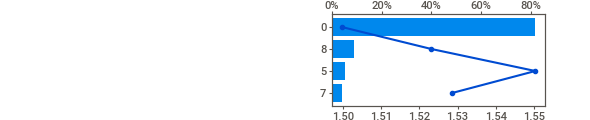
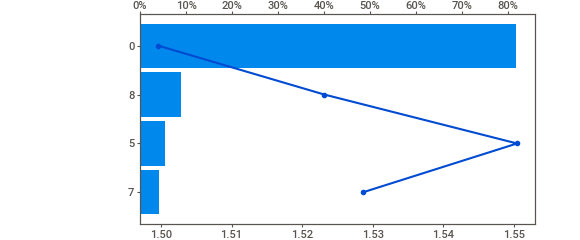
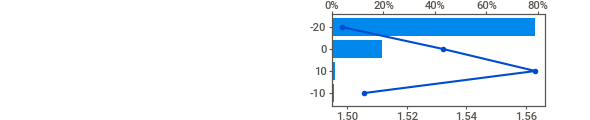
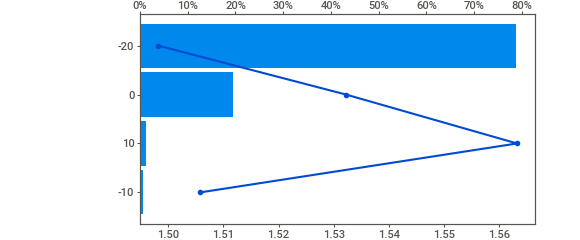
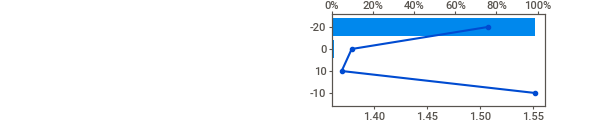
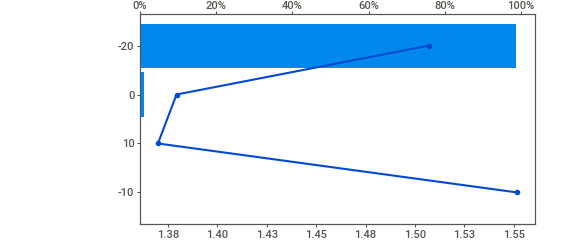
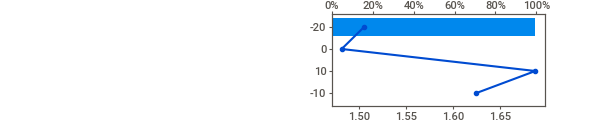
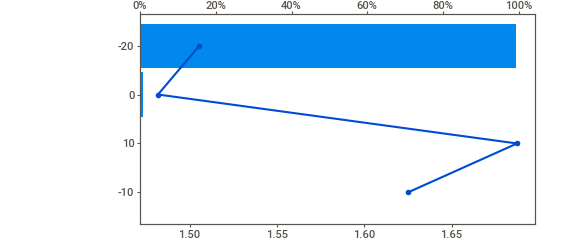
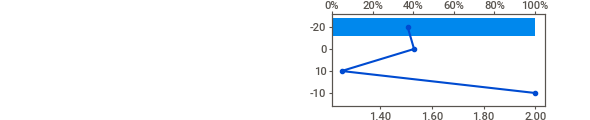
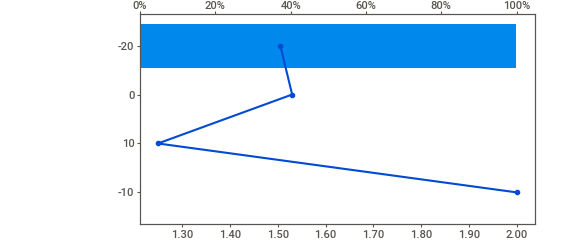
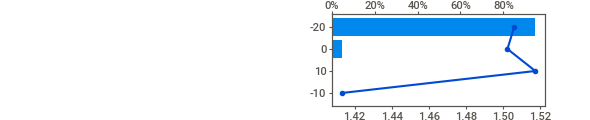
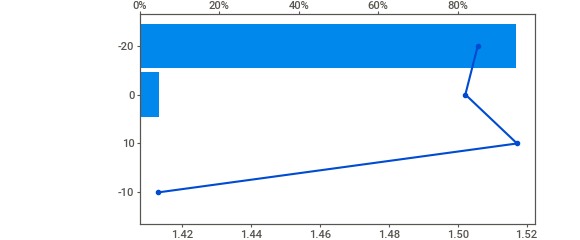
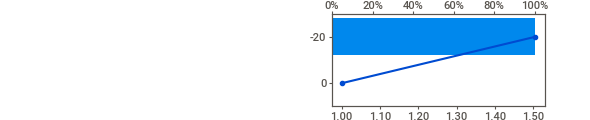
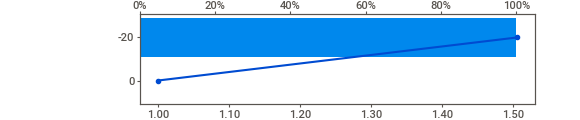
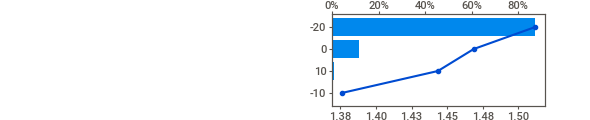
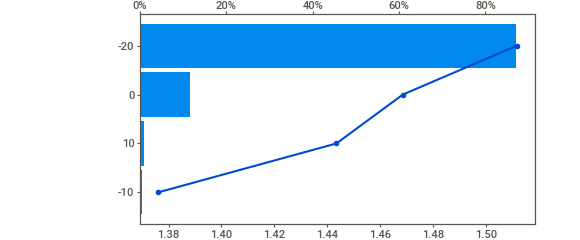
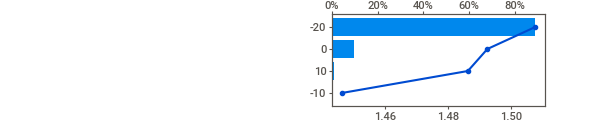
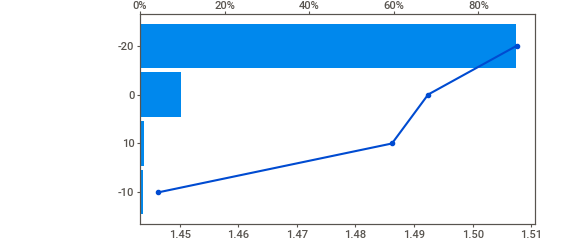
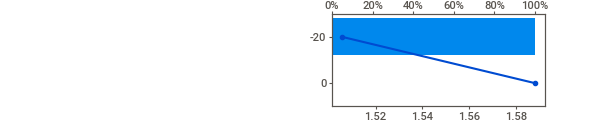
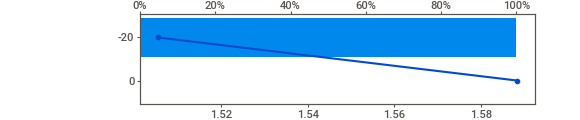
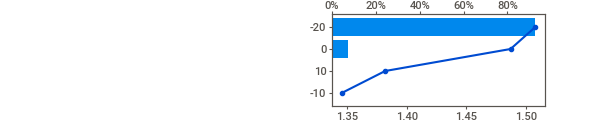
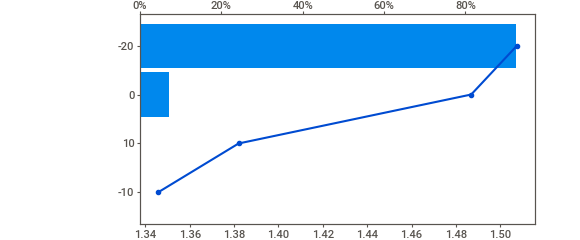
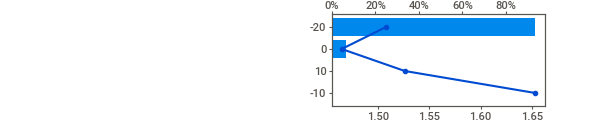
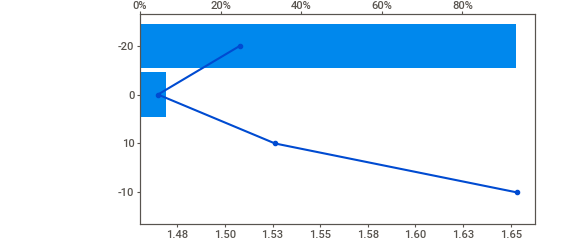
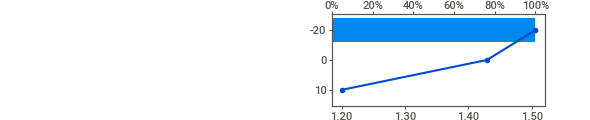
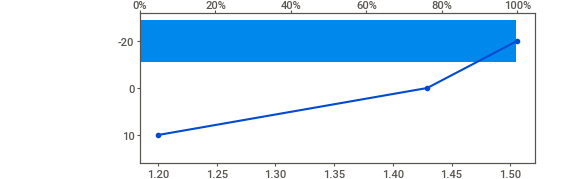
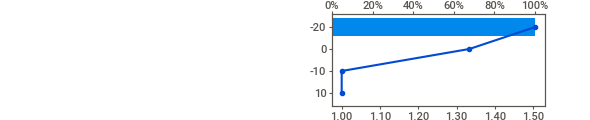
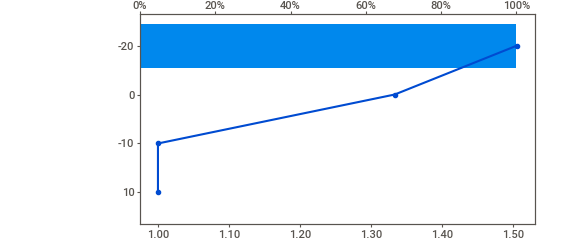
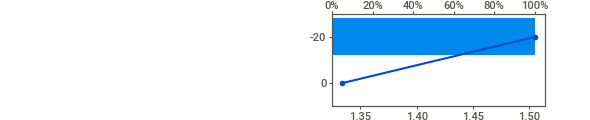
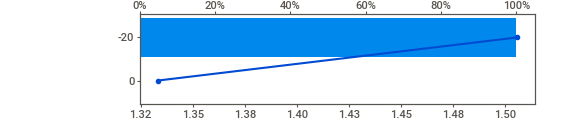
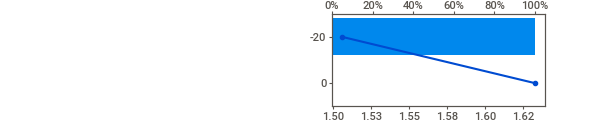
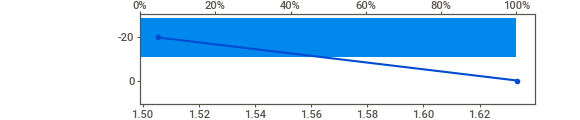
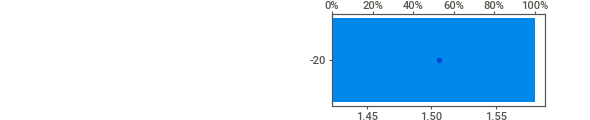
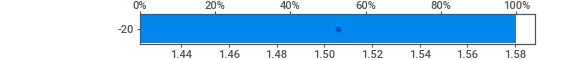
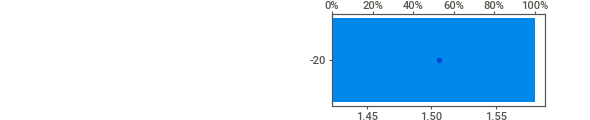
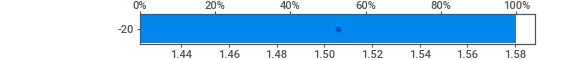
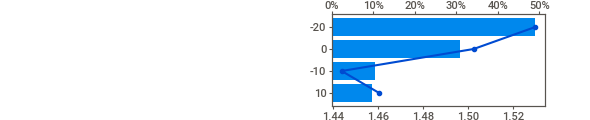
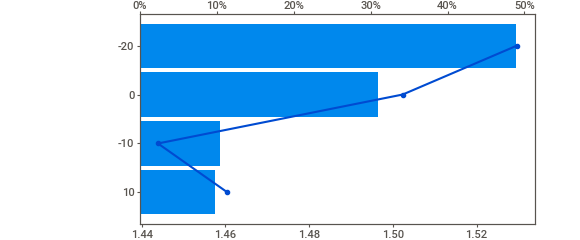
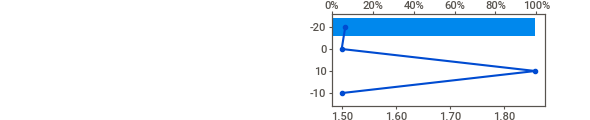
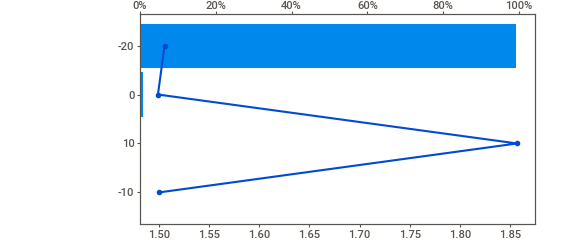
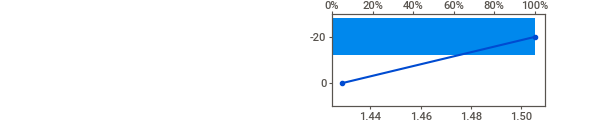
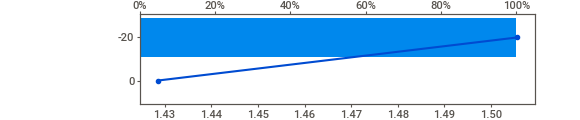
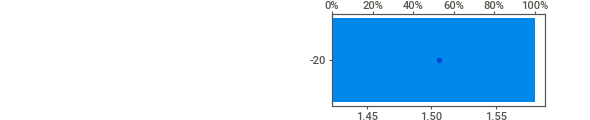
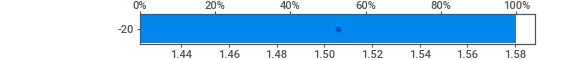
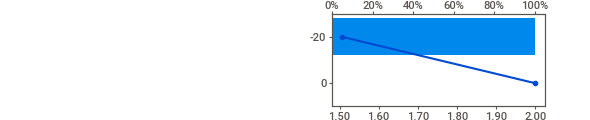
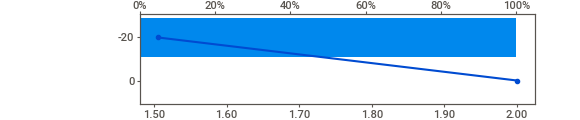
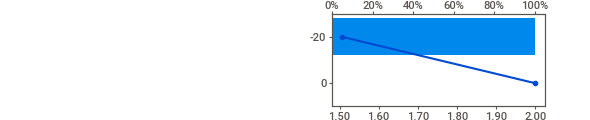
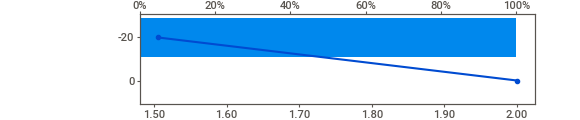
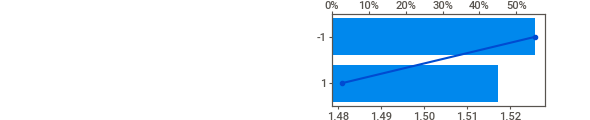
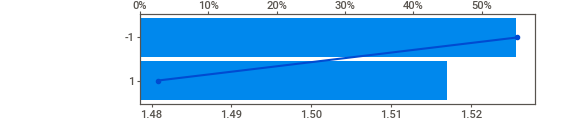
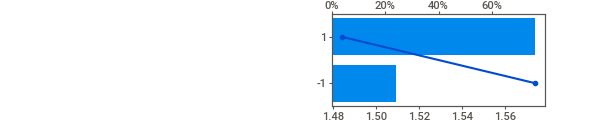
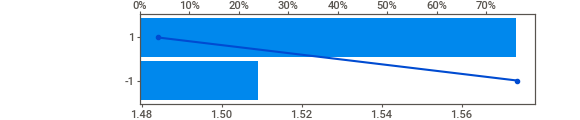
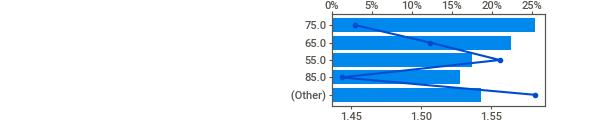
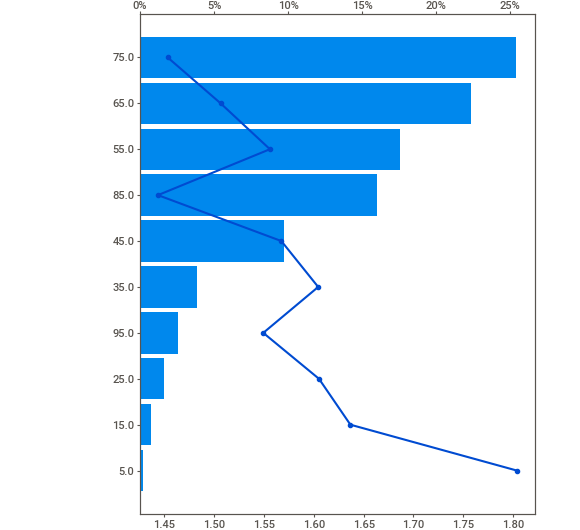
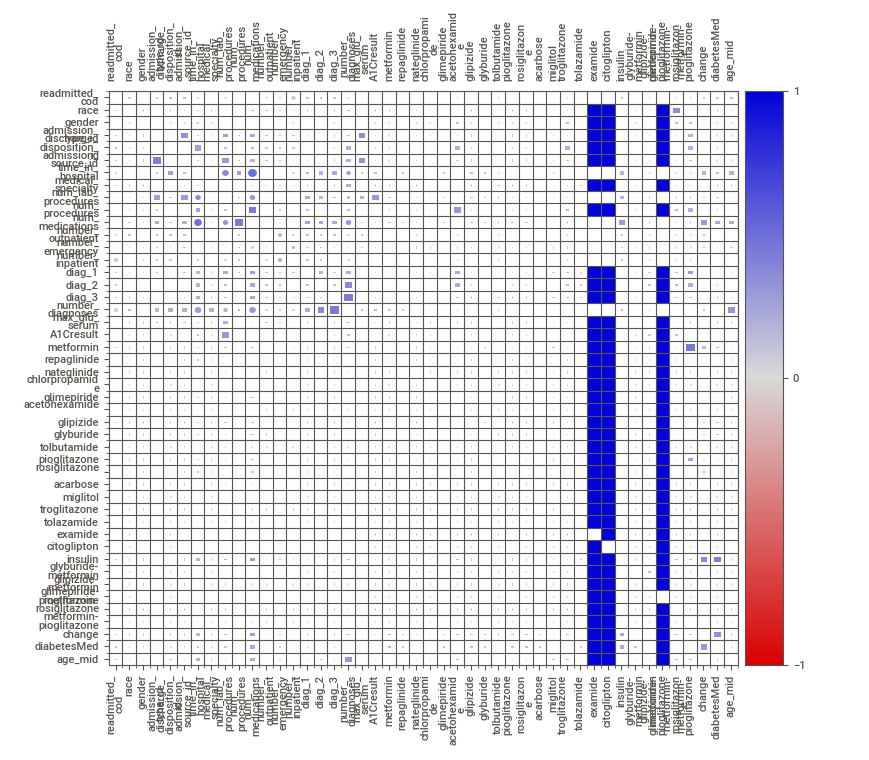
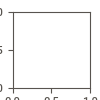

In [147]:
from IPython.display import HTML
reporte.show_html()
display(HTML('SWEETVIZ_REPORT.html'))

A continuación se enfatizan en algunos resultados de variables predictoras que pueden mejorar el entendimiento sobre la variable objetivo.

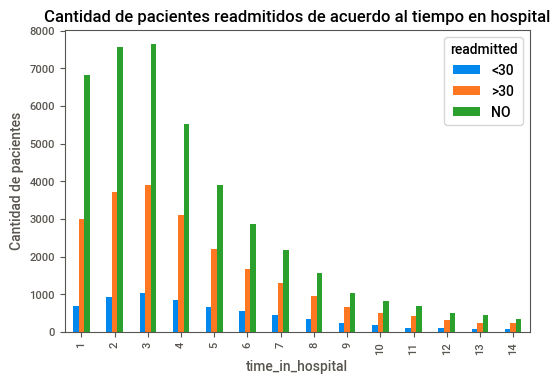

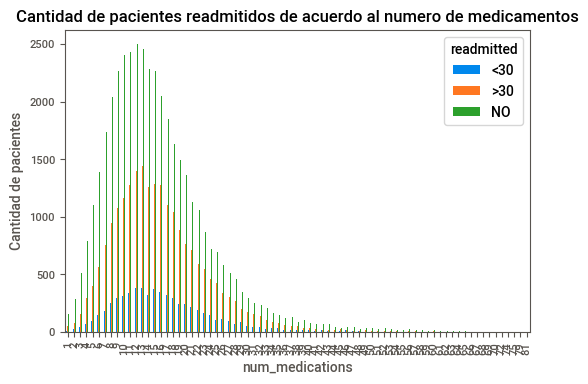

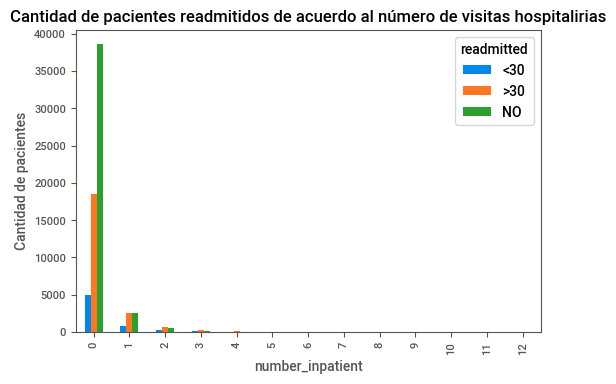

In [377]:
def grafique(var, title):
  pd.crosstab(df['readmitted'], df[var], margins = False).T.plot.bar()
  plt.title(title)
  plt.ylabel('Cantidad de pacientes')
  plt.show()

grafique('time_in_hospital', title = 'Cantidad de pacientes readmitidos de acuerdo al tiempo en hospital')
grafique('num_medications', title = 'Cantidad de pacientes readmitidos de acuerdo al numero de medicamentos')
grafique('number_inpatient', title = 'Cantidad de pacientes readmitidos de acuerdo al número de visitas hospitalirias')



En las tres graficas anteriores se observan diferencias relativas de la cantidad de readmitidos. De manera descriptiva, se observa asociación entre estas variables y readmisión.

Ahora se realizará un análisis descriptivo de las características frente a los pacientes readmitidos:
* Se confirman los hallazgos con respecto a la simetría de las variables `time_in_hospital`, `num_lab_procedures` y `num_medications`. Estas tienen sesgo a la derecha. Se puede corregir este problema transformándolas mediante `log`.
* El género no parece indicar si un paciente será readmitido.
* Entre mayor tiempo en el hospital o numero de procedimientos de laboratorio, es menos probable que el paciente sea readmitido.
* Número de medicamentos no parece mostrar correlación con los pacientes readmitidos.
* Entre mayor el número de visitas hospitalarias, menos probable que un paciente sea readmitido.
* Cuando el número de visitas ambulatorias está entre 30 y 40, disminuye la probabilidad de readmisión.
* Disminuye la cantidad de pacientes readmitidos si el diagnóstico es *embarazada*.
* Entre mayor sea el número de diagnósticos, mayor es la posibilidad de readmisión.
* Los resultados `examide`, `citogliptong`, `glimepiride`, `acetohexamide`, `tolbutamide`, `miglitol`, `troglitazone`, `tolazamide`, `glimepiride-pioglitazone` y `metformin` están muy desbalanceados, por tal motivo se eliminarán estas características de la tabla de datos.

In [149]:
df.drop(columns = ['gender', 'examide', 'citoglipton', 'acetohexamide', 'tolbutamide', 'miglitol', 'troglitazone', 'tolazamide', 'glimepiride-pioglitazone', 'metformin-pioglitazone'], inplace = True)

Mediante la prueba chi cuadrada se analiza la dependencia entre las variables categóricas y la variable objetivo. Si el valor-p es menor a 0.4, se asume  dependencia y por tanto la variable se mantiene, de lo contrario se elimina.

In [261]:
from scipy.stats import chi2_contingency

target_features = ['readmitted', 'readmitted_cod']

numeric_features = list(df.select_dtypes(include=['int','float']).columns)

categorical_features = []
rejected_features = []

for col in df.columns :
    if col not in numeric_features + target_features:
        categorical_features.append(col)

for col in categorical_features : 
    df_crosstab = pd.crosstab(df['readmitted'],  
                                df[col], 
                                margins = False) 

    stat, p, dof, expected = chi2_contingency(df_crosstab)
    if p < 0.4 :
	    print(p, col, 'es significante')
    else:
        print(p, col, 'not es significant')
        rejected_features.append(col)

categorical_features = list(set(categorical_features)- set(rejected_features))
print('\n\n', rejected_features)
df.drop(rejected_features, axis = 1, inplace = True)

1.433580299047126e-17 race es significante
8.460787867684963e-65 admission_type_id es significante
2.3489254647096393e-190 discharge_disposition_id es significante
2.1049560735945086e-113 admission_source_id es significante
0.029115964600441975 medical_specialty es significante
1.0645392322356633e-79 diag_1 es significante
1.8315894155188802e-48 diag_2 es significante
1.0507544712492371e-30 diag_3 es significante
1.6318091707389488e-21 change es significante
2.7875342685774678e-59 diabetesMed es significante


 []


De este resultado se confirma la selección de variables de manera descriptiva realizada anteriormente.

Ahora se realizará un análisis similar para las variables numéricas, usando el coeficiente de correlación de *spearman*.

In [262]:
from scipy.stats import spearmanr
rejected_features = []

print('\n\n')
for col in numeric_features :
    rho , pval = spearmanr(df['readmitted'], df[col])
    if pval < 0.4 : 
        print(col, 'es significante')
    else : 
        print(col, 'no es significante')
        rejected_features.append(col)

print('\n\nLas características rechazadas son:\n', rejected_features)
df.drop(columns = rejected_features, inplace=True)

numeric_features = list(set(numeric_features)- set(rejected_features))




time_in_hospital es significante
num_lab_procedures es significante
num_procedures es significante
num_medications es significante
number_outpatient es significante
number_emergency es significante
number_inpatient es significante
number_diagnoses es significante
max_glu_serum es significante
A1Cresult es significante
metformin es significante
repaglinide es significante
nateglinide es significante
glipizide es significante
glyburide es significante
pioglitazone es significante
rosiglitazone es significante
acarbose es significante
insulin es significante
metformin-rosiglitazone es significante
age_mid es significante


Las características rechazadas son:
 []


De acuerdo al resultado anterior, finalmente se realizará el modelo con 33 variables.

In [263]:
print('número de características de análisis:',len(df.columns))

número de características de análisis: 33


### Codificación a variable dummy

Ahora, las variables categóricas se pasarán a One Hot Encoding para alimentar el modelo y las variables numéricas se estandarizan con media 0 y varianza 1. Por trazabilidad y mejor manejo de la información se utiliza el paquete `sklearn_pandas`.

In [358]:
feature_def_cat = gen_features(
    columns= np.array(categorical_features).reshape(-1,1).tolist(),
    classes= [{'class': SimpleImputer, 'strategy':'most_frequent'},
             {'class': OneHotEncoder, 'drop':'first'}]
)

feature_def_num = gen_features(
    columns= np.array(numeric_features).reshape(-1,1).tolist(),
    classes= [StandardScaler]
)

mapper = DataFrameMapper(feature_def_cat + feature_def_num, df_out = True)

## Variables para incorporar al modelo
Finalmente, se tiene todo listo para incorporar las variables al modelo.

In [363]:
X = mapper.fit_transform(df)
y = df.readmitted
pd.concat([X, y], axis=1)

,diag_2_x0_diabetes,diag_2_x0_digestive,diag_2_x0_genitourinary,diag_2_x0_injury,diag_2_x0_musculoskeletal,diag_2_x0_neoplasms,diag_2_x0_other,diag_2_x0_pregnecy,diag_2_x0_respiratory,discharge_disposition_id_x0_2,discharge_disposition_id_x0_7,discharge_disposition_id_x0_10,discharge_disposition_id_x0_18,discharge_disposition_id_x0_27,discharge_disposition_id_x0_28,diag_3_x0_diabetes,diag_3_x0_digestive,diag_3_x0_genitourinary,diag_3_x0_injury,diag_3_x0_musculoskeletal,diag_3_x0_neoplasms,diag_3_x0_other,diag_3_x0_pregnecy,diag_3_x0_respiratory,race_x0_Asian,race_x0_Caucasian,race_x0_Hispanic,race_x0_Other,change,medical_specialty_x0_low_freq,medical_specialty_x0_neurology,medical_specialty_x0_pediatrics,medical_specialty_x0_psychic,medical_specialty_x0_surgery,medical_specialty_x0_ungrouped,diabetesMed,diag_1_x0_diabetes,diag_1_x0_digestive,diag_1_x0_genitourinary,diag_1_x0_injury,diag_1_x0_musculoskeletal,diag_1_x0_neoplasms,diag_1_x0_other,diag_1_x0_pregnecy,diag_1_x0_respiratory,admission_type_id_x0_3,admission_type_id_x0_4,admission_type_id_x0_5,admission_source_id_x0_4,admission_source_id_x0_7,admission_source_id_x0_8,admission_source_id_x0_9,admission_source_id_x0_11,glyburide,insulin,num_procedures,number_inpatient,num_lab_procedures,pioglitazone,rosiglitazone,nateglinide,repaglinide,A1Cresult,max_glu_serum,time_in_hospital,acarbose,age_mid,number_outpatient,number_emergency,metformin,glipizide,number_diagnoses,num_medications,metformin-rosiglitazone,readmitted
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.346899,-0.930945,-0.810367,-0.293179,-0.096301,-0.28288,-0.265114,-0.083458,-0.11369,-0.463344,-0.202689,-1.116999,-0.053197,-3.787798,-0.263072,-0.203177,-0.512111,-0.378461,-3.116697,-1.770770,-0.005329,NO
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.346899,1.823950,-0.810367,-0.293179,0.808107,-0.28288,-0.265114,-0.083458,-0.11369,-0.463344,-0.202689,-0.436657,-0.053197,-3.161891,-0.263072,-0.203177,-0.512111,-0.378461,0.884715,0.281701,-0.005329,>30
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.346899,-0.930945,2.038802,1.364503,-1.603647,-0.28288,-0.265114,-0.083458,-0.11369,-0.463344,-0.202689,-0.776828,-0.053197,-2.535984,1.615399,-0.203177,-0.512111,2.534822,-0.615815,-0.321967,-0.005329,NO
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.346899,1.823950,-0.240533,-0.293179,0.054434,-0.28288,-0.265114,-0.083458,-0.11369,-0.463344,-0.202689,-0.776828,-0.053197,-1.910077,-0.263072,-0.203177,-0.512111,-0.378461,-0.115638,0.040234,-0.005329,NO
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.346899,0.905652,-0.810367,-0.293179,0.406148,-0.28288,-0.265114,-0.083458,-0.11369,-0.463344,-0.202689,-1.116999,-0.053197,-1.284170,-0.263072,-0.203177,-0.512111,2.534822,-1.115991,-0.925635,-0.005329,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101754,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0

## Generación de modelos
Se generan varios modelos Machine Learning implementados en el paquete `sklearn`. De acuerdo a estos resultados, se planea utilizar paquetes más flexibles para ajustarlos como `xgboost` o `tensor-flow`.

Se crea la función `evaluate`, la cual permite diagnosticar cada modelo mediante el cálculo del *accuracy*, *f1-score* y *matriz de confusión* sobre los datos de testeo.

------------------------------------------------------------
GaussianNB
accuracy: 0.16
f1 score: 0.16


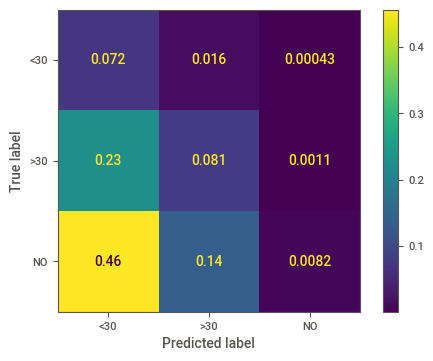

------------------------------------------------------------
DecisionTreeClassifier
accuracy: 0.49
f1 score: 0.36


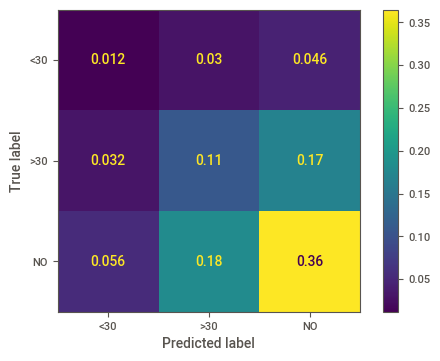

------------------------------------------------------------
RandomForestClassifier
accuracy: 0.61
f1 score: 0.35


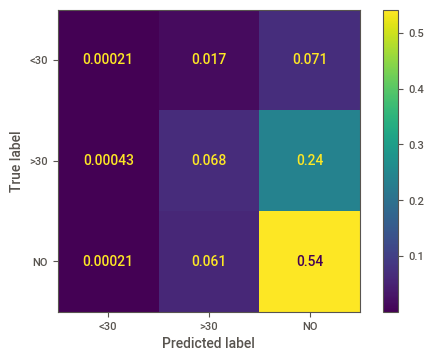

------------------------------------------------------------
AdaBoostClassifier
accuracy: 0.61
f1 score: 0.33


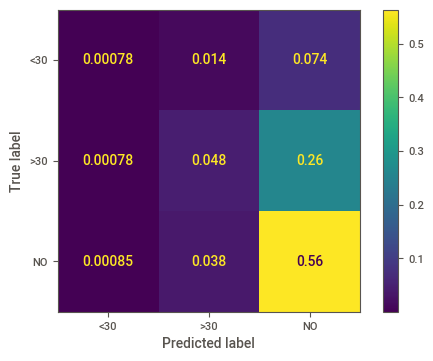

------------------------------------------------------------
GradientBoostingClassifier
accuracy: 0.62
f1 score: 0.33


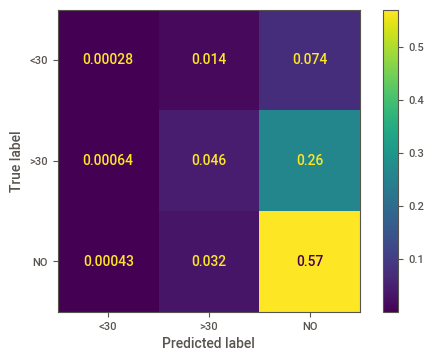

------------------------------------------------------------
XGBClassifier
accuracy: 0.62
f1 score: 0.33


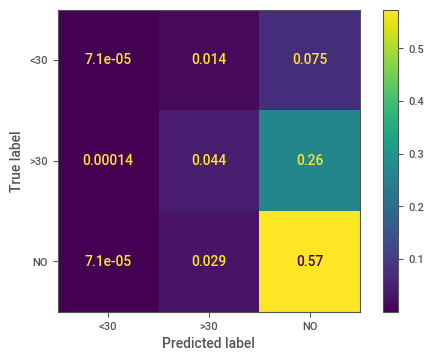

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


------------------------------------------------------------
MLPClassifier
accuracy: 0.35
f1 score: 0.29


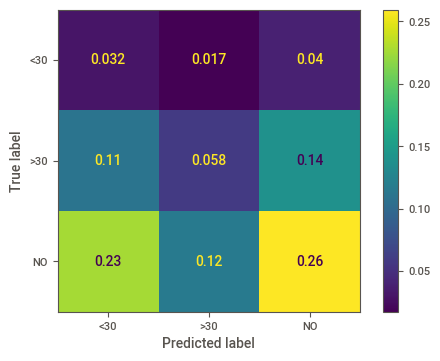

In [361]:
def evaluate(modelo, X_test, y_test):
  y_pred = modelo.predict(X_test)
  print('-'*60 + '\n' + type(modelo).__name__)
  print('accuracy:', round(accuracy_score(y_test, y_pred),2))
  print('f1 score:', round(f1_score(y_test, y_pred, average='macro'),2))
  plot_confusion_matrix(modelo, X_test, y_test, normalize='all')
  plt.show()

modelos = [GaussianNB(),                                # Naive Bayes
           DecisionTreeClassifier(),                    # Arbol de decisión
           RandomForestClassifier(),                    # Random Forest
           AdaBoostClassifier(),                        # Modelo ensamble boosting
           GradientBoostingClassifier(),                # Modelo ensamble gradiente
           XGBClassifier(objective="multi:softprob"),   # xgboost
           MLPClassifier(learning_rate_init=0.0000001)] # Red Neuronal

# Separación de los datos en entrenamiento y testeo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

for modelo in modelos:
  modelo.fit(X_train, y_train)
  evaluate(modelo, X_test, y_test)


Los mejores resultados se obtienen con los modelos basados en árboles de decisión. Obteniendo un *accuracy* máximo del 61% y un F1-score del 35%. Dado este resultado se realiza una grilla de búsqueda mediante la función `GridSearchCV` para encontrar el mejor modelo `RandomForest`.

In [342]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100],
    'min_samples_leaf': [1, 5, 10],
    'min_samples_split': [2, 4, 6],
    'n_estimators': [100, 200, 300]
}

grid_search = GridSearchCV(estimator = RandomForestClassifier(), param_grid = param_grid, 
                          cv = 2, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, y_train)

Fitting 2 folds for each of 81 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 21.4min
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed: 21.9min finished


GridSearchCV(cv=2, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

mejores parámetros: {'bootstrap': True, 'max_depth': 90, 'min_samples_leaf': 5, 'min_samples_split': 4, 'n_estimators': 200}
------------------------------------------------------------
RandomForestClassifier
accuracy: 0.61
f1 score: 0.33


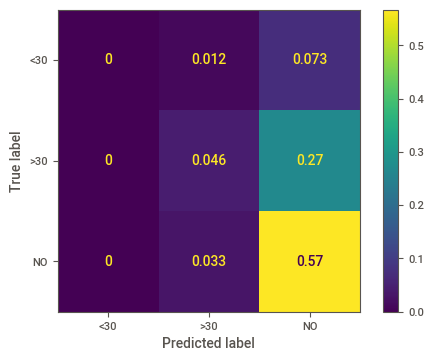

In [352]:
print('mejores parámetros:', grid_search.best_params_)
best_grid = grid_search.best_estimator_
evaluate(best_grid, X_test, y_test)

Se observa que el mejor modelo `RandomForest` no pronostica ningún readmitido menor a 30 días. Lo cual es un serio problema que origina bastantes falsos positivos. Por tanto se recomienda el modelo que `skelearn` selecciona por defecto.

## Conclusiones

De acuerdo a los resultados obtenidos se concluye:

1. La readmisión de pacientes está más asociada a los diagnósticos de los pacientes, el tiempo en el hospital, número de procedimientos de laboratorio y visitas hospitalarias.
2. Algunos resultados de exámenes de laboratorio como *examide, citogliptong, glimepiride, acetohexamide, tolbutamide, miglitol, troglitazone, tolazamide, glimepiride-pioglitazone y metformin* arrojan un solo factor. Este desbalance no aporta información a los modelos propuestos.
3. El género del paciente no se asocia a la readmisión de un paciente.
4. El mejor modelo de pronóstico es *RandomForest* sobre otros basados en árboles de decisión, modelos probabilísticos o en redes neuronales.
5. Dado el desbalance de la variable objetivo (readmisión de pacientes), se dificulta mejorar las métricas de desempeño de los modelos. Se obtuvo un *accuracy* y *F1-score* iguales a 61% y 35%, respectivamente.

## Trabajo futuro

Para mejorar el desempeño del modelo *RandomForest* se plantea:

1. Realizar modelo de regresión logística multiclase, para continuar evaluando las variables explicativas que más impactan en el pronóstico de la variable objetivo y descartar aquellas que tengan colinealidad entre ellas o no sean significativas.
2. Realizar métricas de bajo-ajuste y sobre-ajuste que permitan ajustar los hiperparámetros de manera manual.
3. Reducir la dimensionalidad de las variables explicativas mediante análisis de componentes principales o VAE (variational auto-encoder). En este espacio reducido observar cualquier patrón que permita identificar el significado de las variables latentes.
4. Desarrollar una función de costo que penalice los errores de pronóstico en los pacientes readmitidos menores a 30 días.